In [ ]:
#!pip install neptune-client
#!pip install neptune-neptune_pytorch_lightning

NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="


!pip install pytorch-lightning

#!pip install -U git+https://github.com/albumentations-team/albumentations_experimental


import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor #ToTensorV2, ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from collections import OrderedDict

     |████████████████████████████████| 808kB 4.2MB/s 
     |████████████████████████████████| 829kB 12.9MB/s 
     |████████████████████████████████| 276kB 20.0MB/s 
     |████████████████████████████████| 10.6MB 18.7MB/s 
     |████████████████████████████████| 112kB 45.3MB/s 
     |████████████████████████████████| 645kB 37.4MB/s 
     |████████████████████████████████| 1.3MB 36.9MB/s 
     |████████████████████████████████| 143kB 44.9MB/s 
     |████████████████████████████████| 296kB 38.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=797736d8627e64289a6e061a83d32ccfdb72215baa12ec9bec56dcc9a175eb25
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [55]:
images_path = '/content/gdrive/My Drive/Anapix/vpc_autocropped_224/'

In [56]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [57]:
images_path = 'vpc_autocropped_224/'

In [ ]:
class ResnetMulti9cl(LightningModule):  #récupération de notre modèle
        def __init__(self, hparams):
          super().__init__()
          self.save_hyperparameters(hparams)
          self.batch_size = hparams['batch_size']
          self.lr = hparams['lr']
          self.workers = hparams['workers']
          self.test_results = []
          self.test_labels = []
          
          self.model = models.resnet50(pretrained=True)
          self.num_features = self.model.fc.in_features
          self.model.fc = torch.nn.Linear(self.num_features, 512)

        
        def forward(self, x):
          x = self.model(x)
          return x

ckpt_path_198_TES_5 = 'siamese/TES-5/checkpoints/epoch=9-step=11739.ckpt'
model_198_TES_5 = ResnetMulti9cl.load_from_checkpoint(checkpoint_path=ckpt_path_198_TES_5)
model_198_TES_5.freeze()  #blocage des neurones aléatoires

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [58]:
yanal_label=pd.read_csv('yanal_label.csv', sep=',')
yanal_label.drop(yanal_label[yanal_label['patient_id']==199].index, axis=0, inplace=True) #enlever le patient 199 car on a pas ses images
yanal_label.set_index(['patient_id','image'], inplace = True) #double indexer notre data
model_X=model_198_TES_5.model

patient_id=0
patients=[]
for index, row in yanal_label.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    patient_infos = yanal_label.loc[index[0]]
    #patient = patient.unstack()
    print(patient_infos)

    columns=['patient_id','image','concensus']
    for k in range(1,513):
      columns.append("feature "+str(k))
    patient = pd.DataFrame(None, columns=columns)

    #for index_image in range (1,patient_infos.shape[0]+1):
    for index_image,row in patient_infos.iterrows():
      img_name = images_path + patient_infos["path"][index_image]
      print(img_name)
      
      if not os.path.isfile(img_name):
          print('not found', img_name)
          raise IOError(f'The following file was not found: {img_name}')

      image = cv2.imread(img_name)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image/255
      image = ToTensor()(image=image)['image'].float()
      image = image.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle

      predicteurs = model_X(image)    
      ligne=[index[0],index_image,patient_infos["concensus"][index_image]]
      for i in range(len(predicteurs[0])):
        ligne.append(float(predicteurs[0][i]))
      ligne=[ligne]       #on créer une ligne avec les features extraites de notre image qu'on rajoute à notre dataframe patient
      nouvelle_ligne=pd.DataFrame(ligne, columns = columns)
      patient=patient.append(nouvelle_ligne,ignore_index=True)

    patient_id=index[0]
    print(patient)
    patients.append(patient)
    
print(patients)



       patient  concensus        path
image                                
1            1          4   P13I1.JPG
2            1          3   P13I2.JPG
3            1          3   P13I3.JPG
4            1          3   P13I4.JPG
5            1          3   P13I5.JPG
6            1          3   P13I6.JPG
7            1          1   P13I7.JPG
8            1          3   P13I8.JPG
9            1          3   P13I9.JPG
10           1          3  P13I10.JPG
11           1          3  P13I11.JPG
12           1          3  P13I12.JPG
13           1          3  P13I13.JPG
14           1          3  P13I14.JPG
15           1          3  P13I15.JPG
16           1          3  P13I16.JPG
17           1          2  P13I17.JPG
18           1          5  P13I18.JPG
19           1          3  P13I19.JPG
vpc_autocropped_224/P13I1.JPG
vpc_autocropped_224/P13I2.JPG
vpc_autocropped_224/P13I3.JPG
vpc_autocropped_224/P13I4.JPG
vpc_autocropped_224/P13I5.JPG
vpc_autocropped_224/P13I6.JPG
vpc_autocropped_224/P1

In [ ]:
patients[0].describe().loc["std",:].mean()

0.018876336040550893

#APPRENTISSAGE NON SUPERVISEE

##Réduction de dimensionnalité

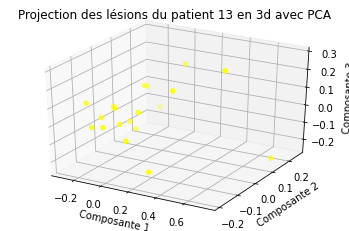

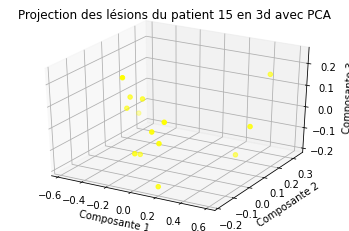

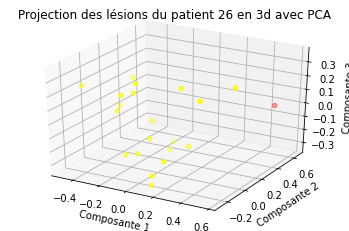

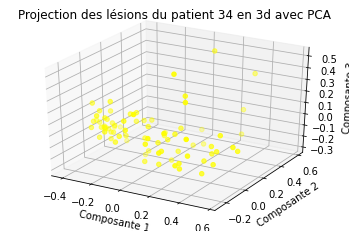

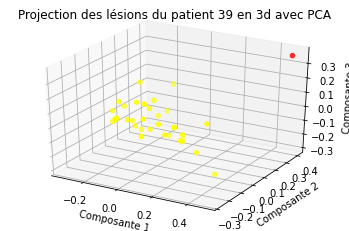

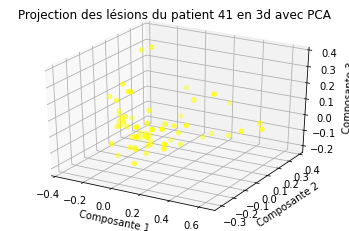

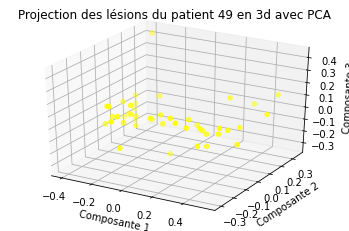

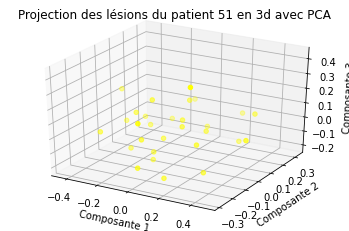

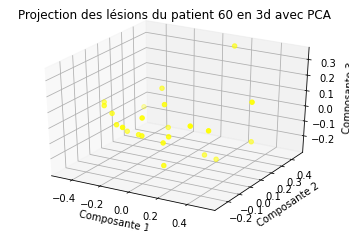

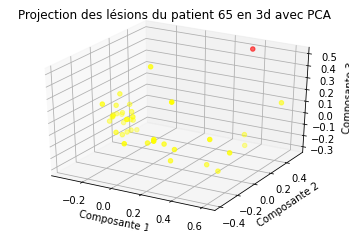

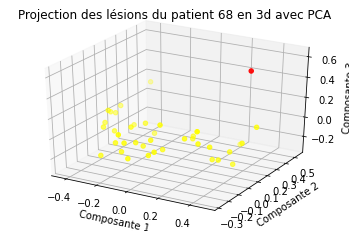

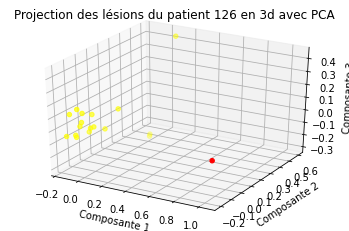

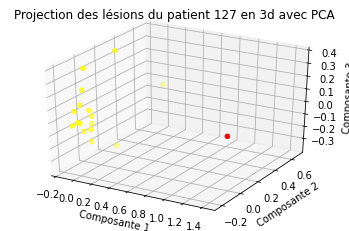

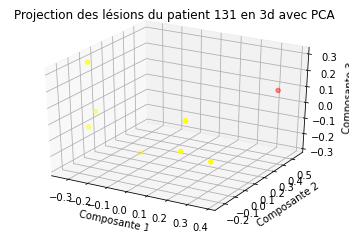

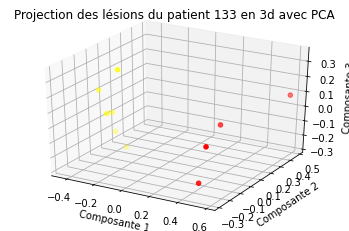

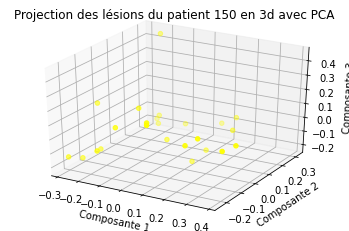

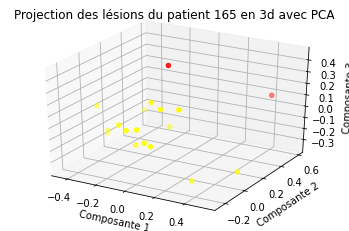

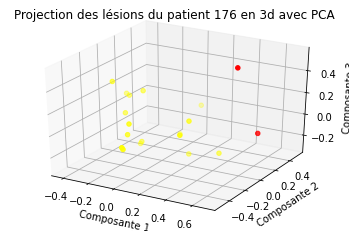

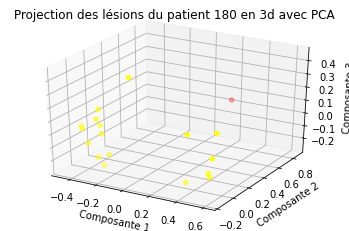

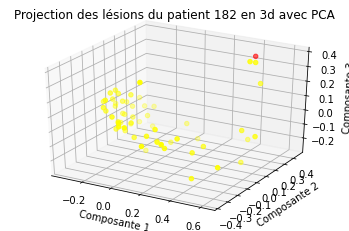

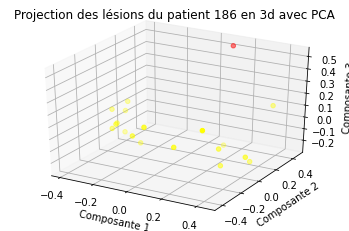

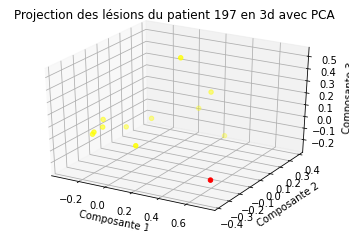

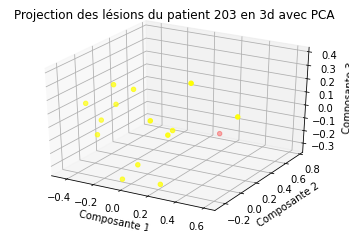

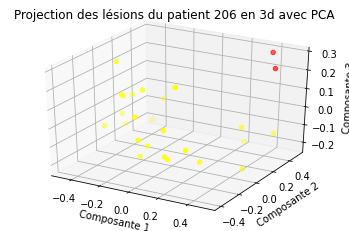

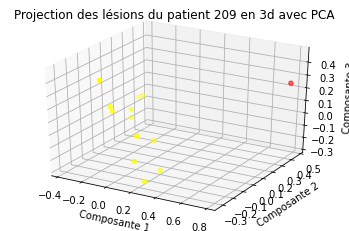

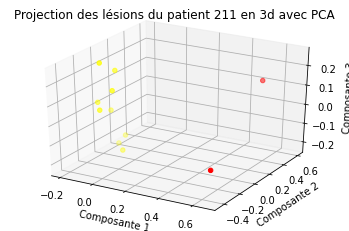

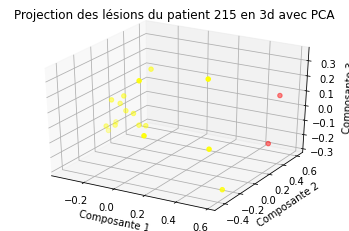

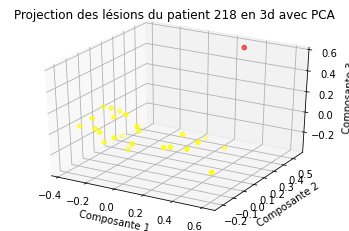

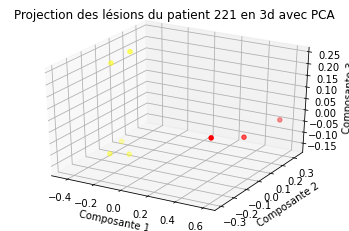

In [ ]:
from copy import deepcopy

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','image','concensus'], axis=1)
  pca = PCA(3)
  pca.fit(X)
  projected = pca.fit_transform(X)
  fig = plt.figure()
  ax = fig.add_subplot(111,projection='3d')
  axe_x=projected[:,0]
  axe_y=projected[:,1]
  axe_z=projected[:,2]
  ax.scatter(axe_x, axe_y, axe_z, c=y)
  ax.set_title("Projection des lésions du patient " +str(patient_id)+ " en 3d avec PCA")
  ax.set_xlabel("Composante 1")
  ax.set_ylabel("Composante 2")
  ax.set_zlabel("Composante 3")
  plt.show()

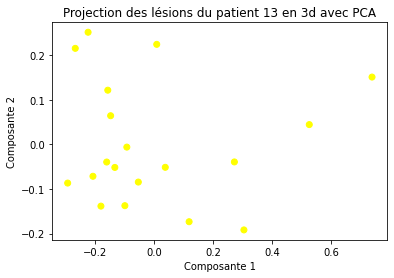

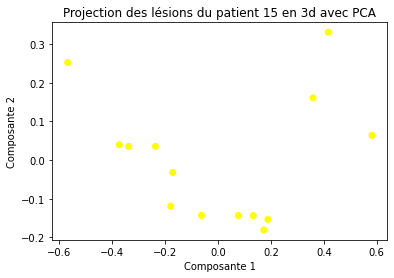

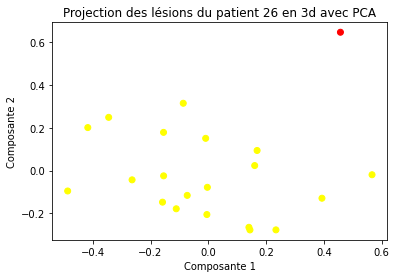

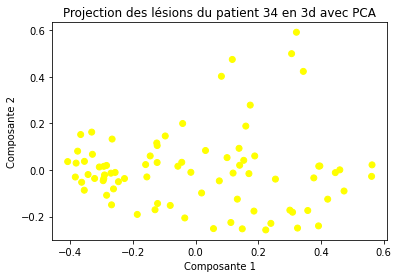

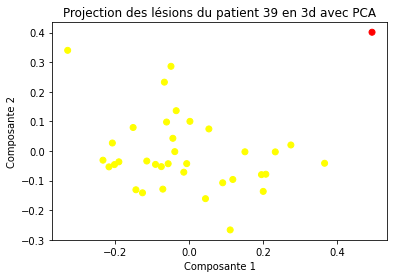

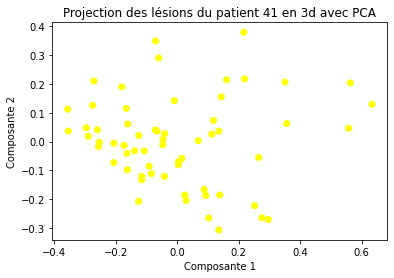

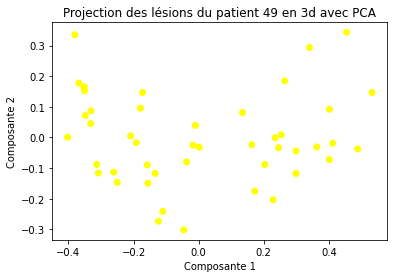

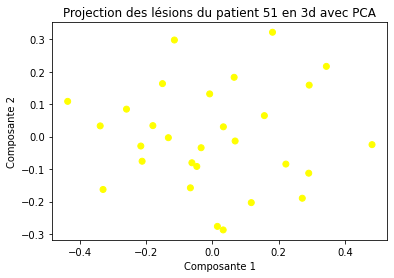

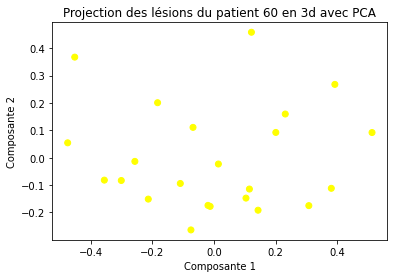

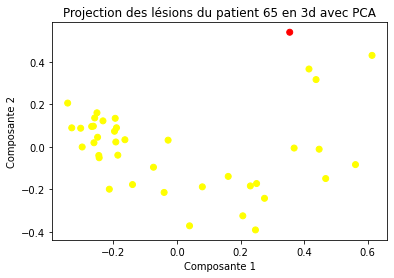

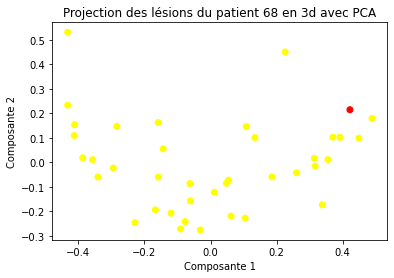

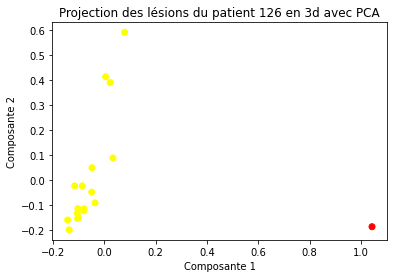

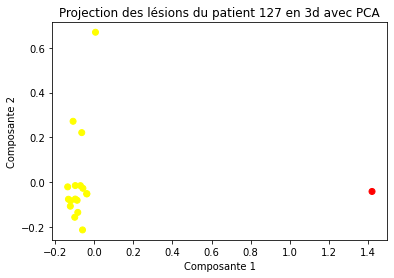

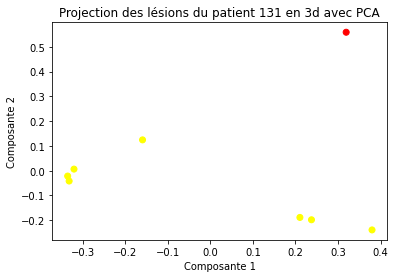

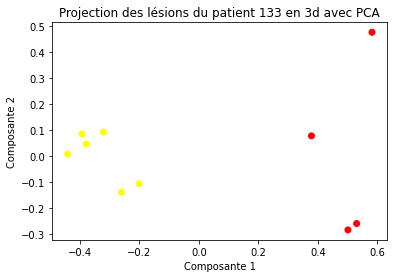

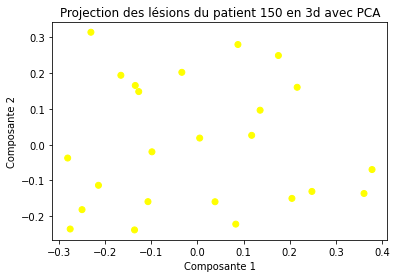

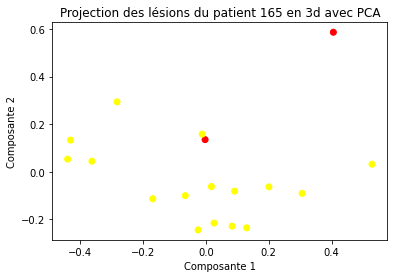

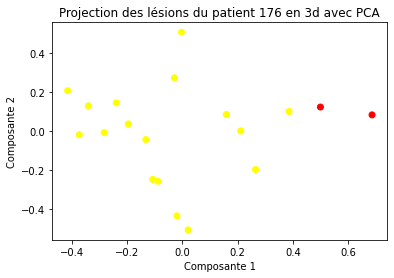

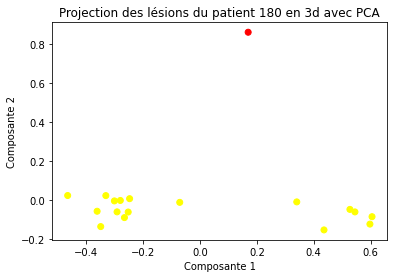

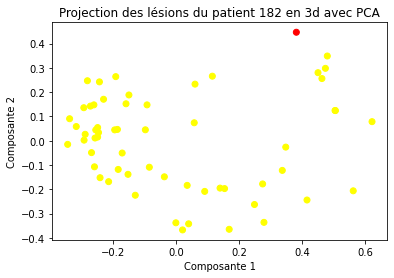

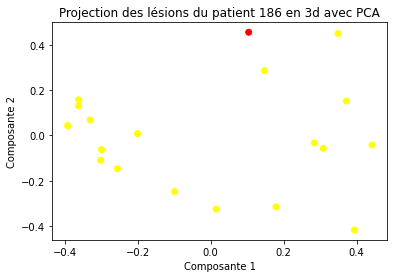

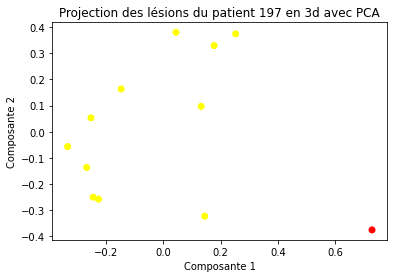

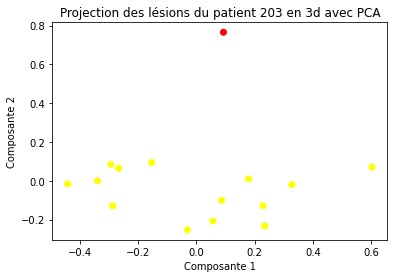

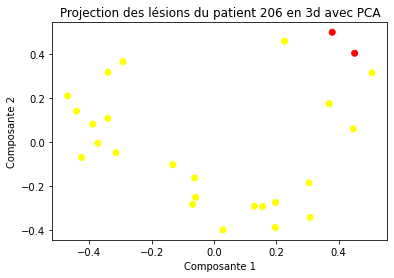

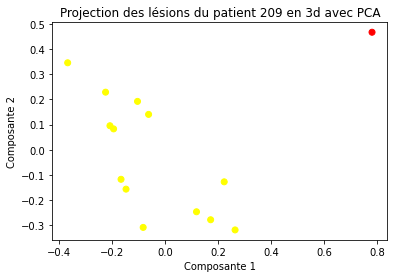

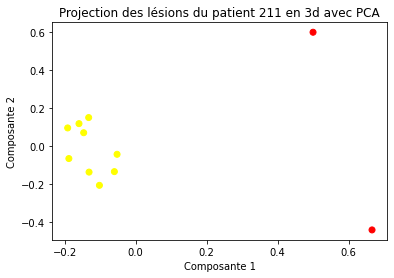

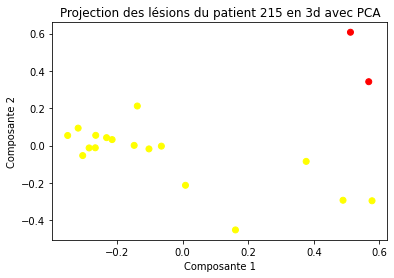

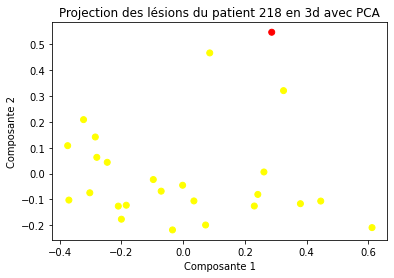

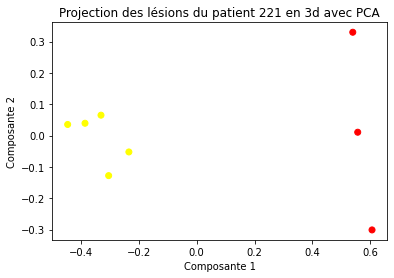

In [ ]:
for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m ]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','image','concensus'], axis=1)
  pca = PCA(2)  
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1],c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 3d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.show()

In [ ]:
from sklearn.manifold import TSNE
for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','image','concensus'], axis=1)
  tsne = TSNE(n_components=3)
  #Modèle t-SNE
  tsne.fit(X)
  '''print('Stores the embedding vectors :', tsne.embedding_)
  print('Kullback-Leibler divergence after optimization :', tsne.kl_divergence_)
  print('Number of iterations run :', tsne.n_iter_)
  print('Get parameters for this estimator :', tsne.get_params())'''
  #Résultats t-SNE
  projected = tsne.fit_transform(X)
  print('On passe d\'une taille de', X.shape, 'à une taille de', projected.shape)

  fig = plt.figure()
  ax = fig.add_subplot(111,projection='3d')
  axe_x=projected[:,0]
  axe_y=projected[:,1]
  axe_z=projected[:,2]
  ax.scatter(axe_x, axe_y, axe_z,c=y)
  ax.set_title("Notre figure en 3d avec t-SNE pour le patient "+str(patient_id))
  ax.set_xlabel("Composante 1")
  ax.set_ylabel("Composante 2")
  ax.set_zlabel("Composante 3")
  plt.show()

## Clustering par les plus proches voisins

C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters).

La similarité entre deux données peut être inférée grâce à la “distance” séparant leurs descripteurs ; ainsi deux données très similaires sont deux données dont les descripteurs sont très proches. Cette définition permet de formuler le problème de partitionnement des données comme la recherche de K “données prototypes”, autour desquelles peuvent être regroupées les autres données.

Ces données prototypes sont appelés centroïdes ; en pratique l’algorithme associe chaque donnée à son centroïde le plus proche, afin de créer des clusters. D’autre part, les moyennes des descripteurs des données d’un cluster, définissent la position de leur centroïde dans l’espace des descripteurs : ceci est à l’origine du nom de cet algorithme.

Pour trouver le nombre de clusters à rentrer dans la fonction KMeans on peut utiliser la "Elbow Method" aussi appelée "Méthode du coude" en utilisant la distorsion du notre clustering, ou bien en utilisant la silhouette de notre clustering.

explication silhouette : https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111

No handles with labels found to put in legend.


(19, 18)


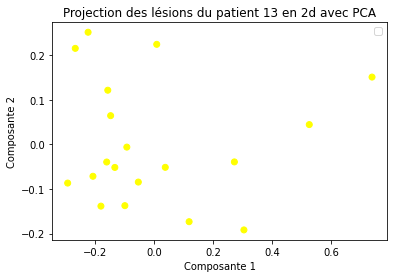

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


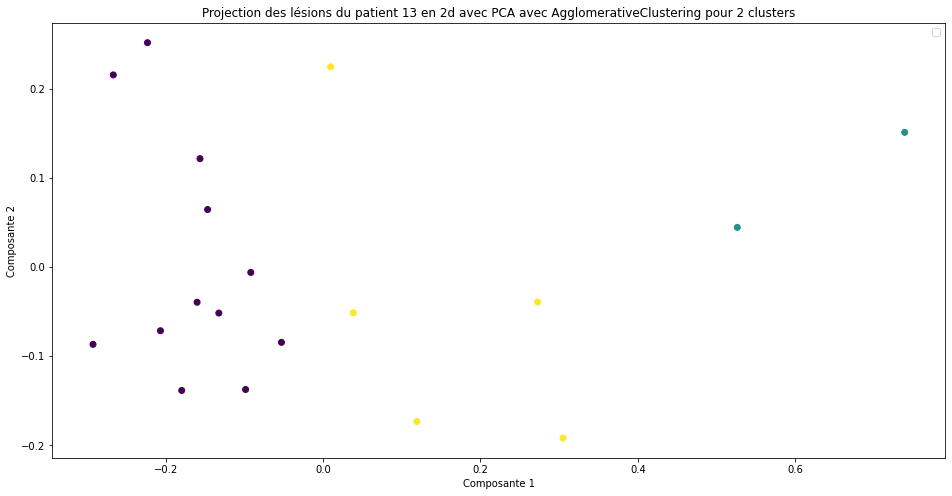

No handles with labels found to put in legend.


(14, 13)


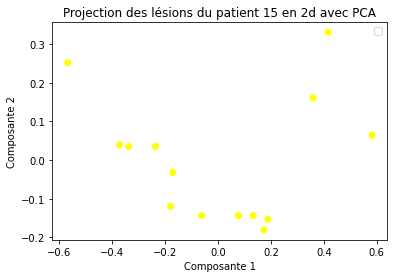

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


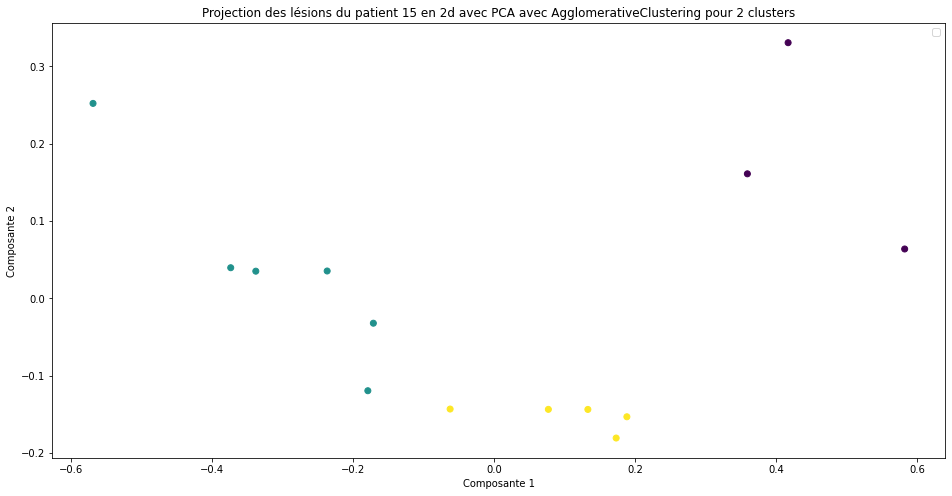

No handles with labels found to put in legend.


(21, 20)


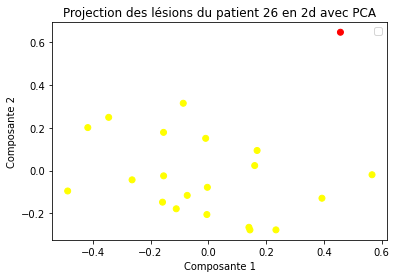

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


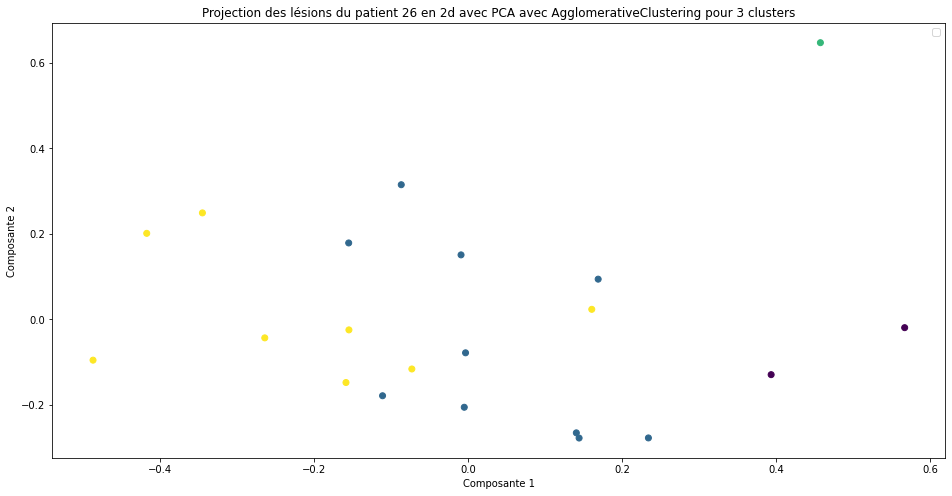

No handles with labels found to put in legend.


(81, 80)


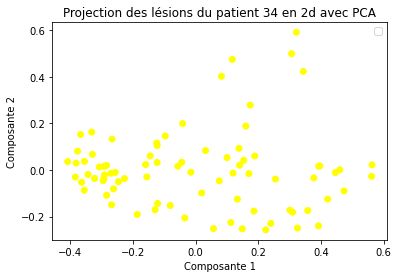

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


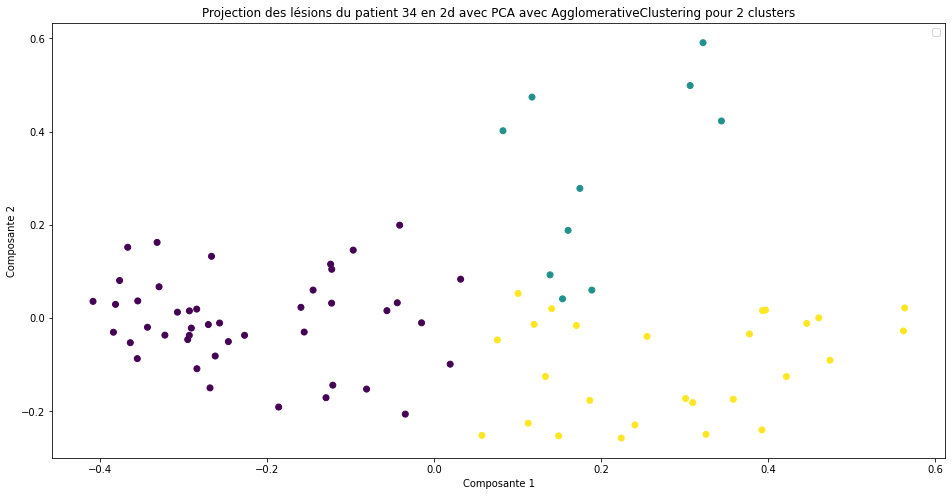

No handles with labels found to put in legend.


(36, 35)


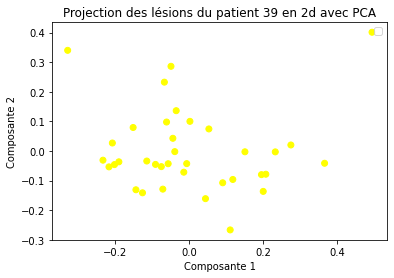

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 1 faux positifs


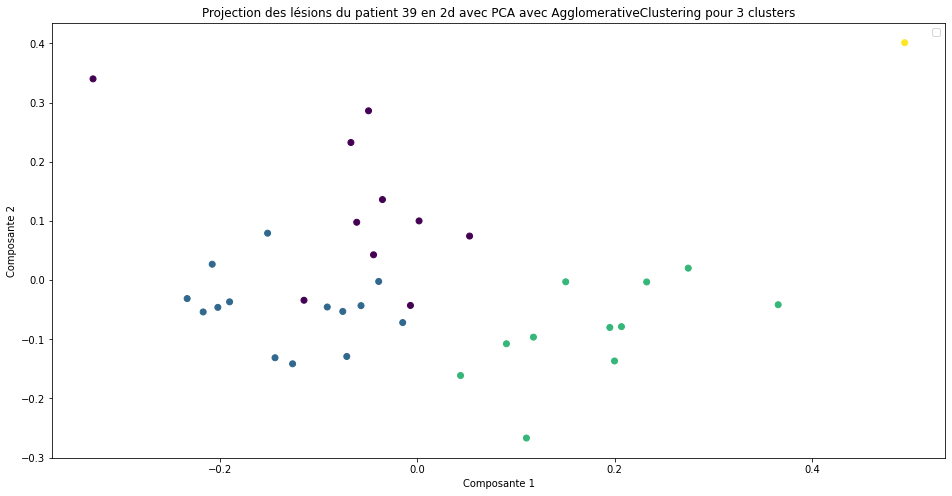

(61, 60)


No handles with labels found to put in legend.


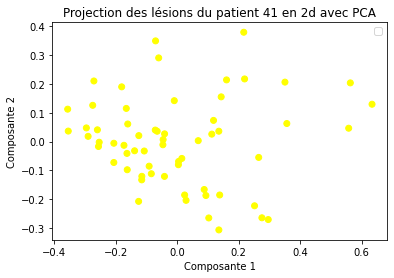

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


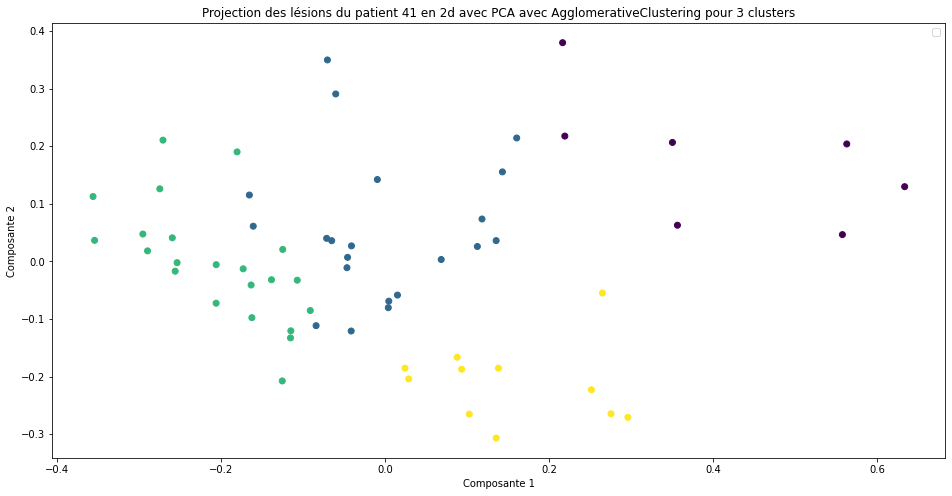

No handles with labels found to put in legend.


(46, 45)


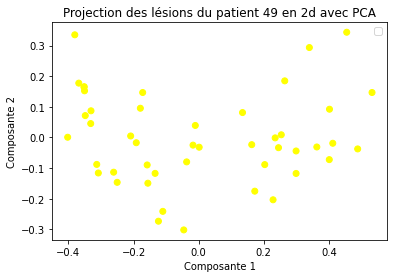

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


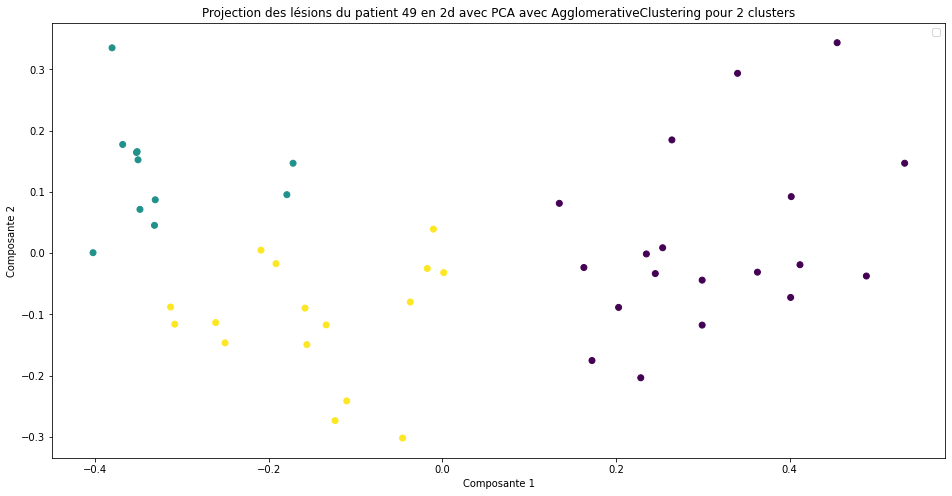

No handles with labels found to put in legend.


(29, 28)


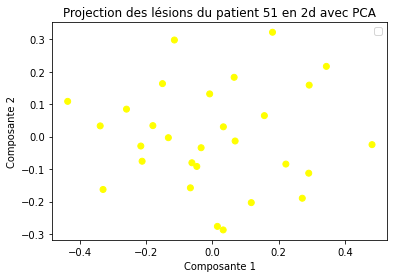

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


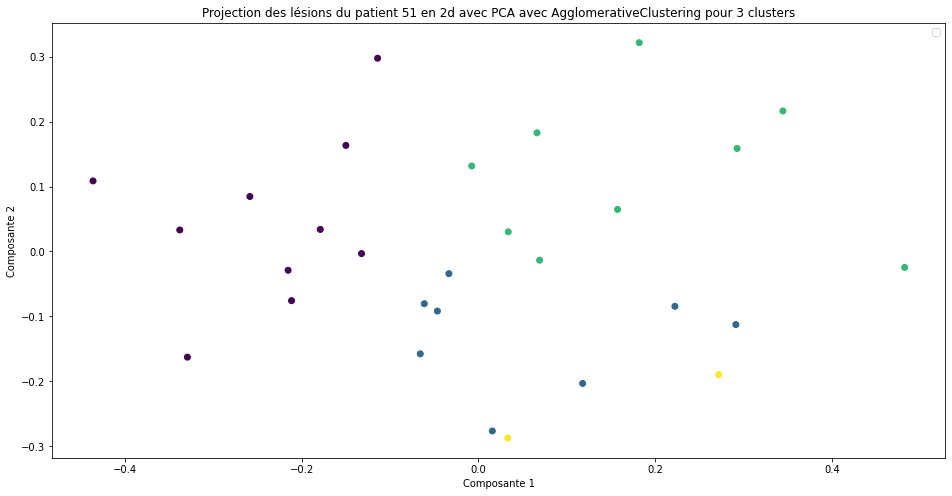

No handles with labels found to put in legend.


(23, 22)


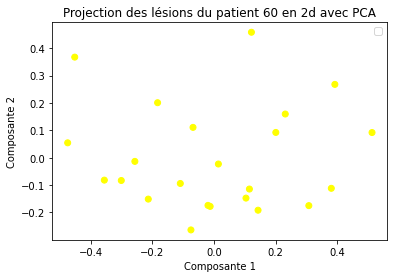

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


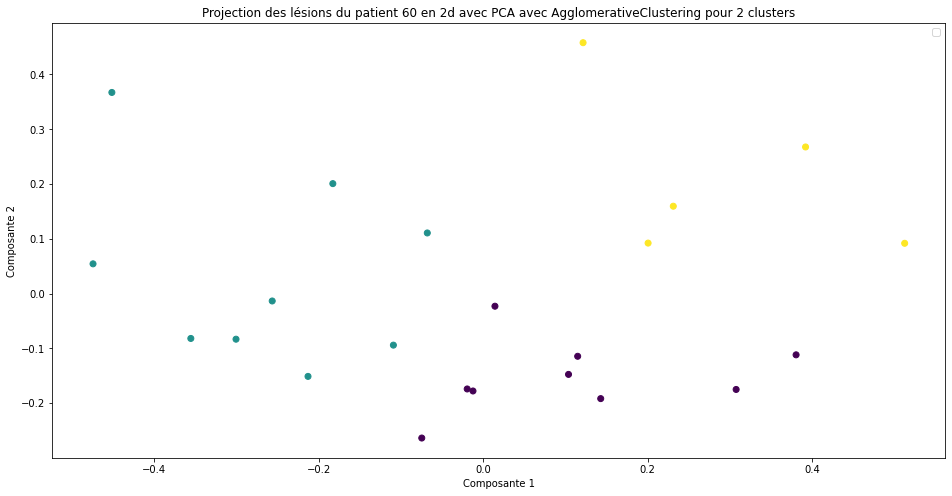

No handles with labels found to put in legend.


(40, 39)


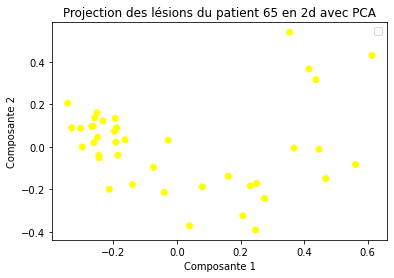

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


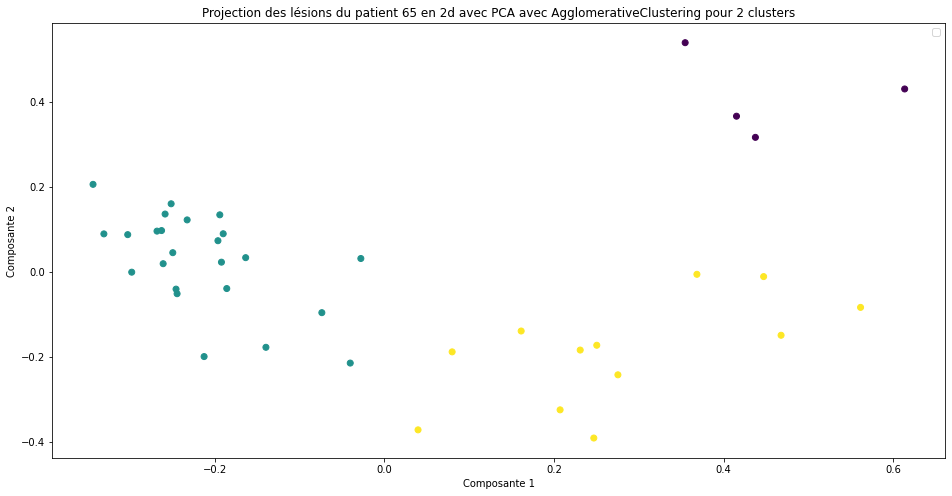

No handles with labels found to put in legend.


(39, 38)


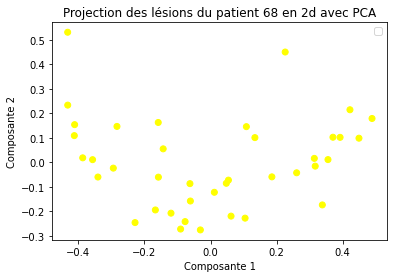

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 0 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 0 faux positifs


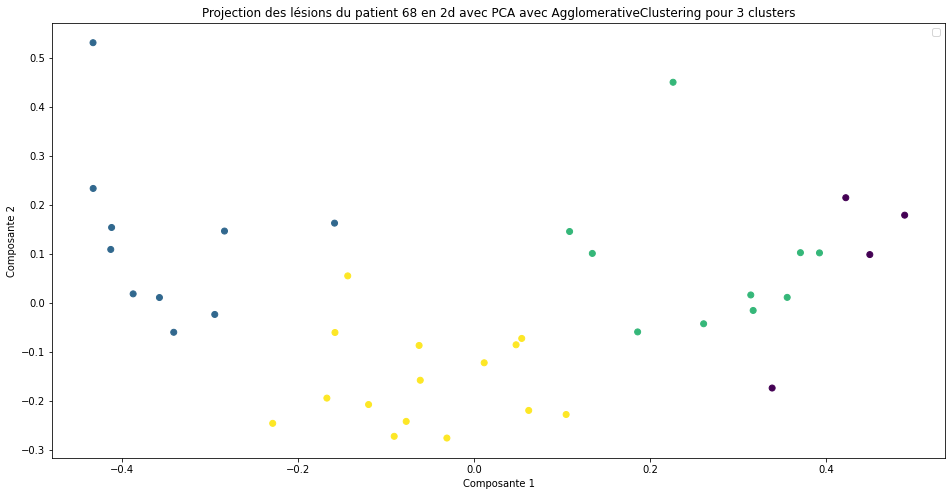

No handles with labels found to put in legend.


(18, 17)


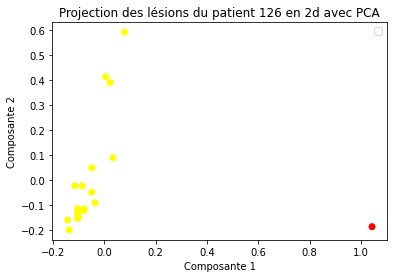

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


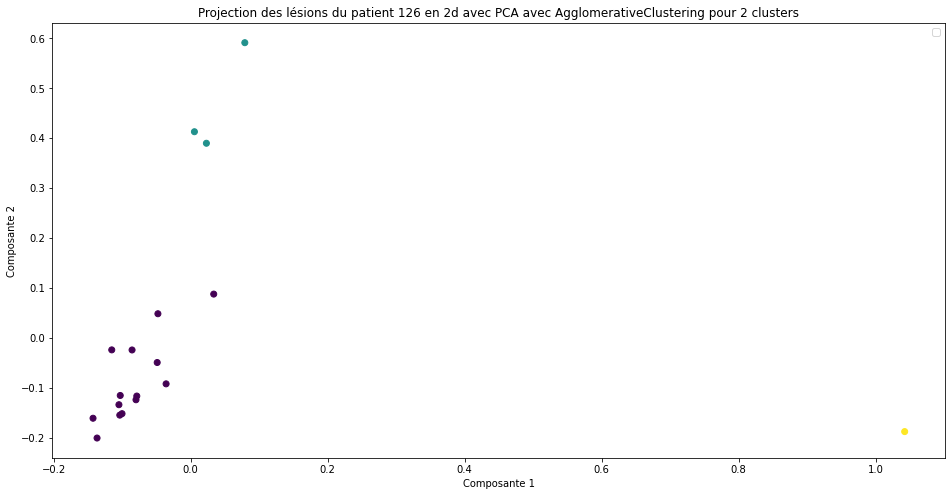

No handles with labels found to put in legend.


(18, 17)


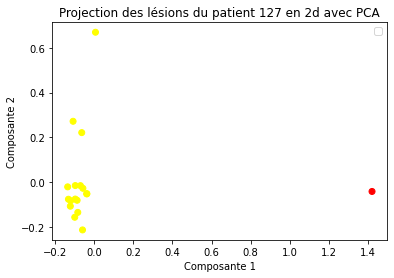

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


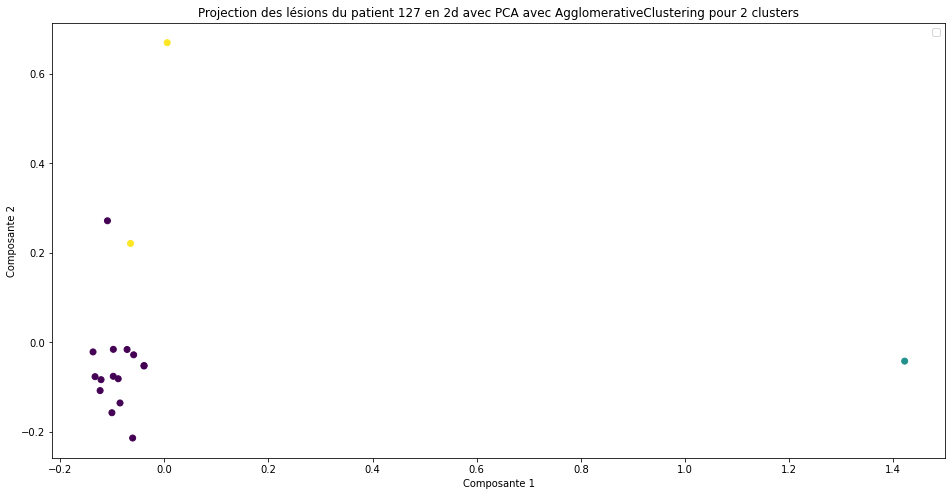

No handles with labels found to put in legend.


(8, 7)


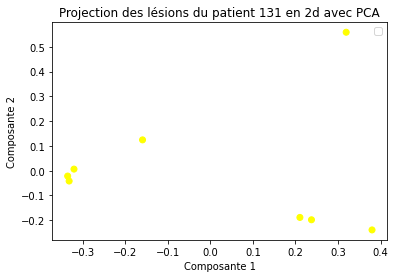

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 1 faux positifs


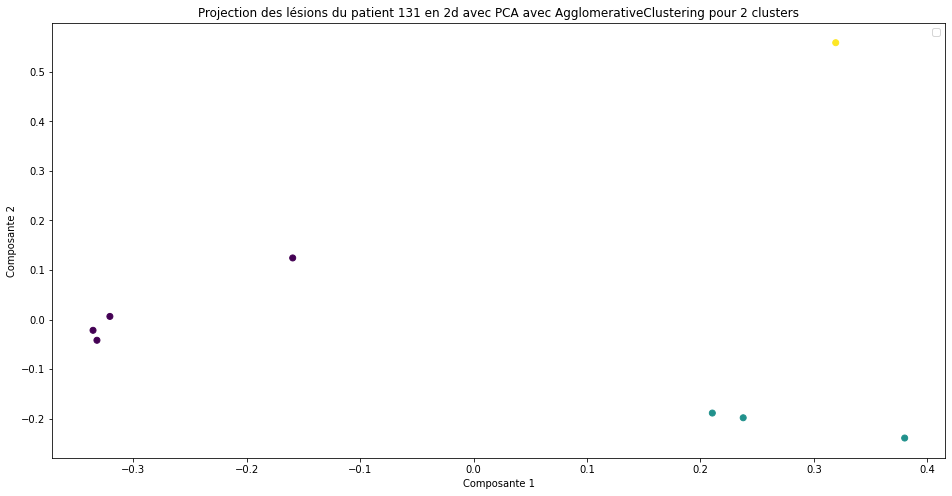

No handles with labels found to put in legend.


(10, 9)


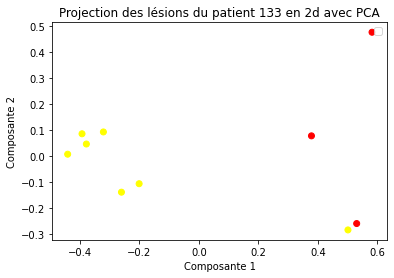

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 3 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 3 dont 0 faux positifs


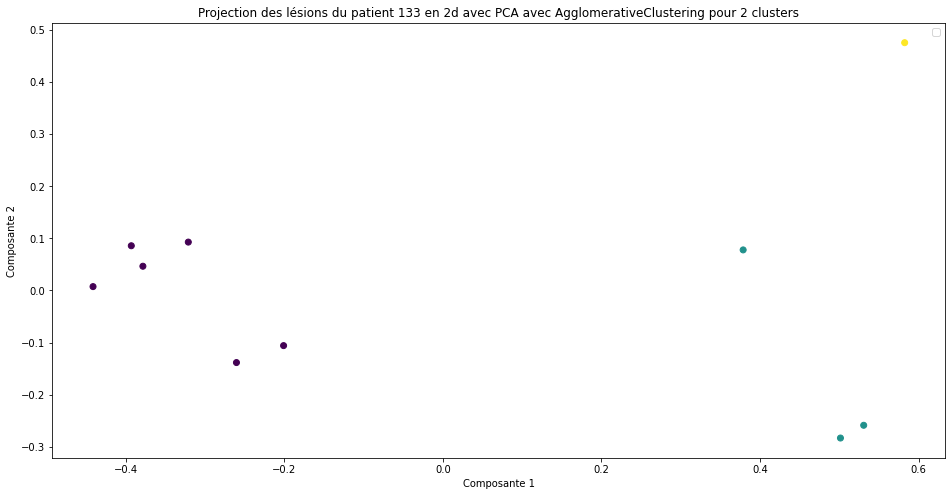

No handles with labels found to put in legend.


(24, 23)


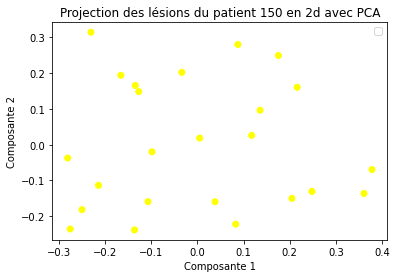

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 1 faux positifs


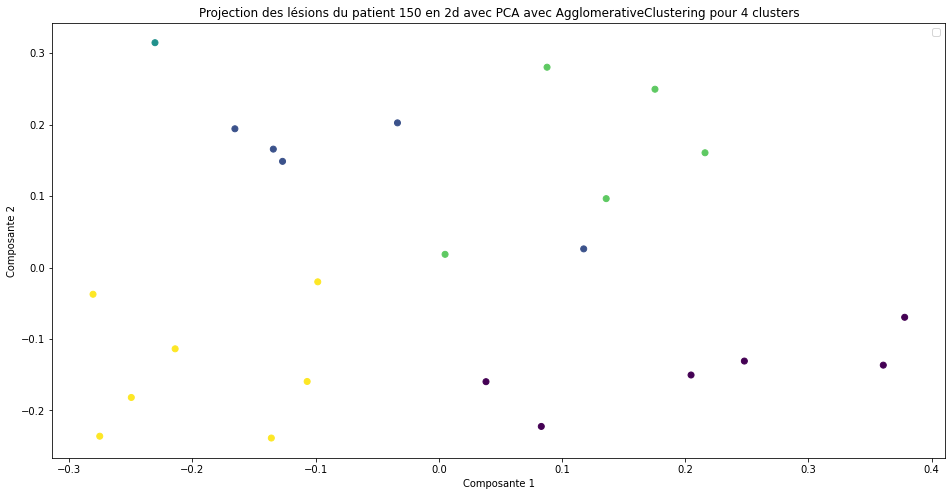

(18, 17)


No handles with labels found to put in legend.


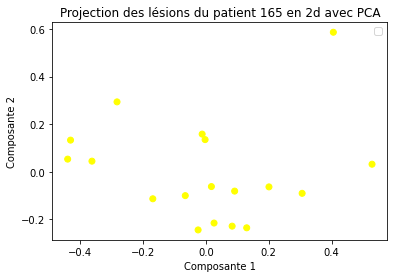

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 1 faux positifs


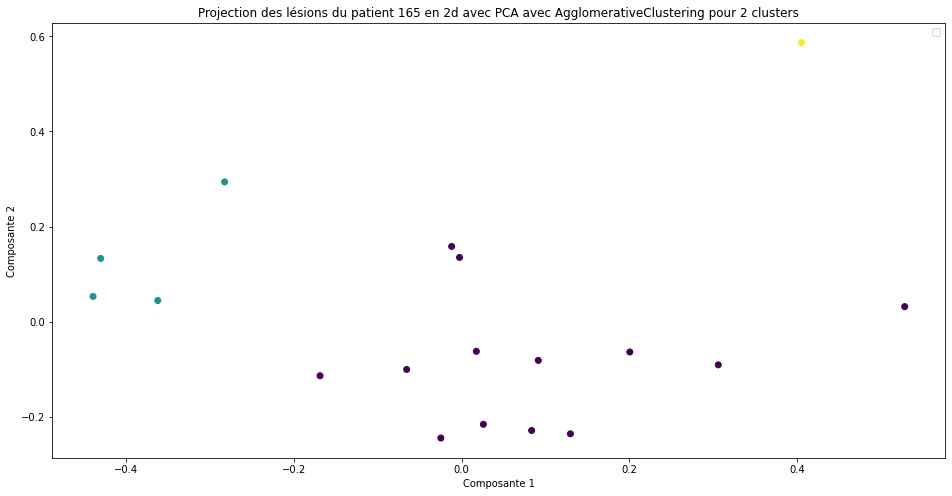

No handles with labels found to put in legend.


(19, 18)


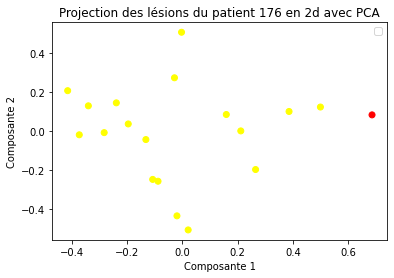

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


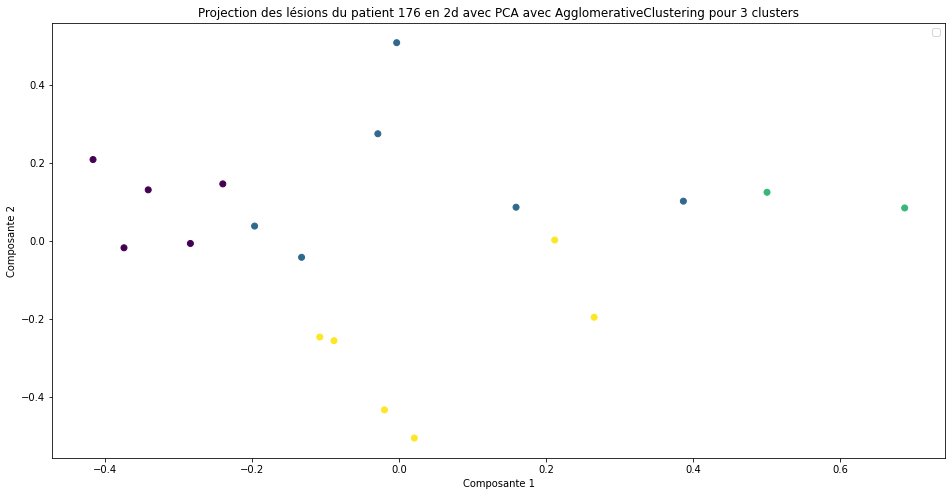

No handles with labels found to put in legend.


(18, 17)


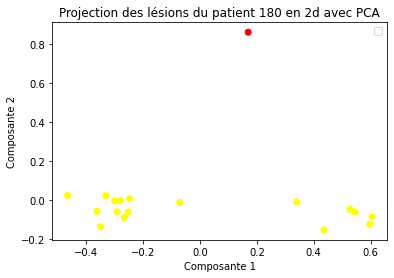

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


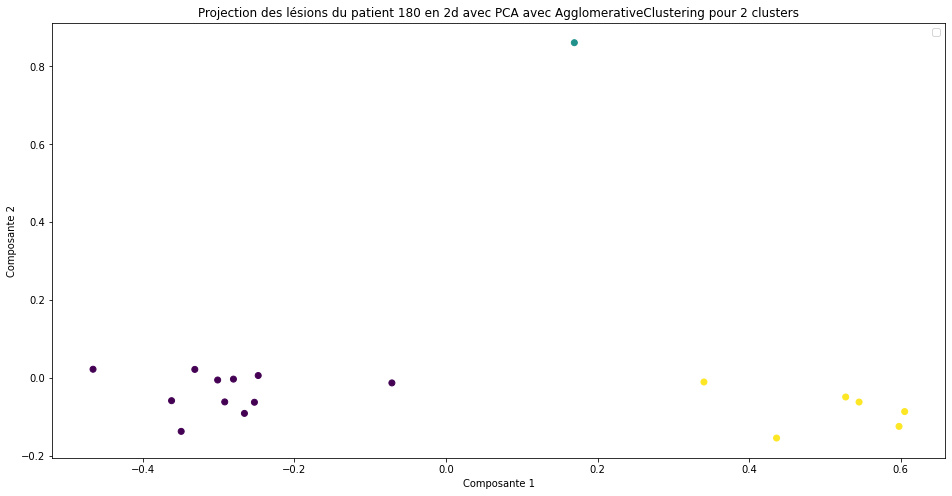

(59, 58)


No handles with labels found to put in legend.


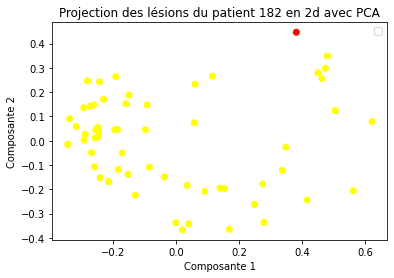

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


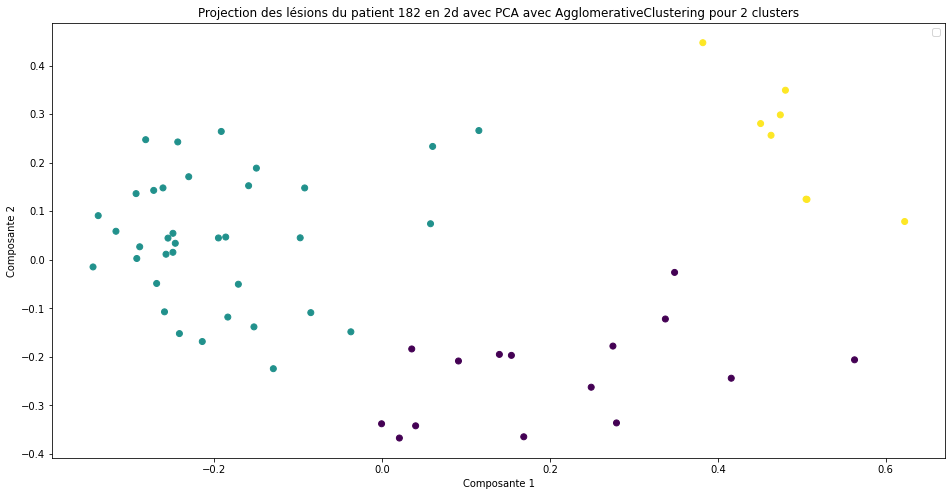

No handles with labels found to put in legend.


(19, 18)


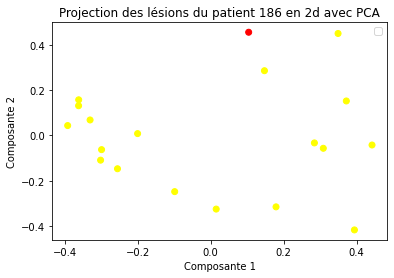

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


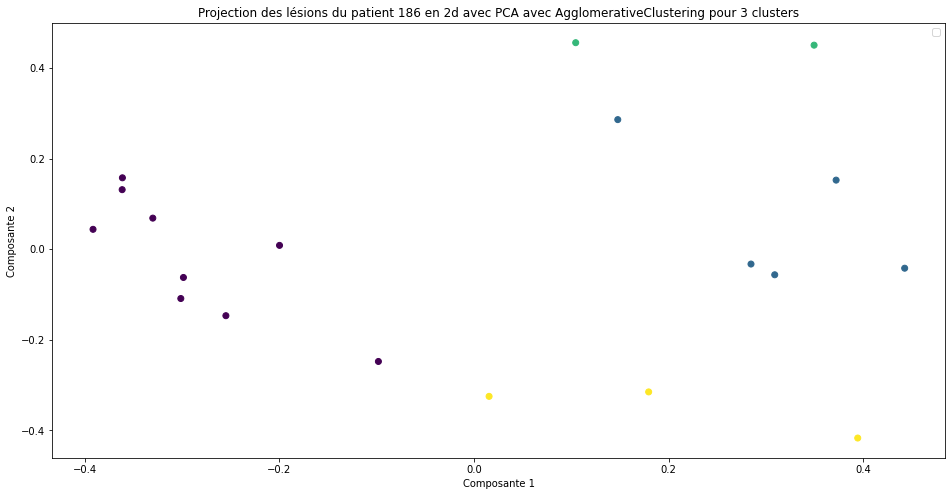

No handles with labels found to put in legend.


(12, 11)


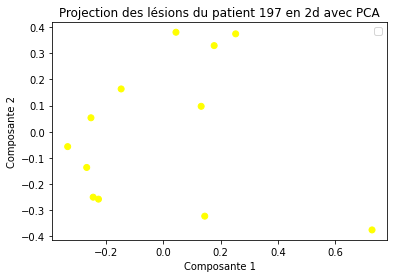

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 0 sur 0 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


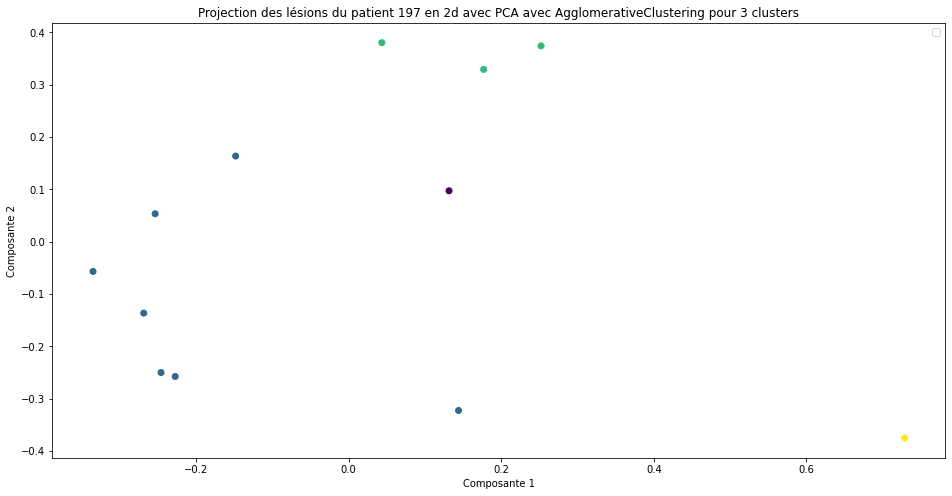

No handles with labels found to put in legend.


(15, 14)


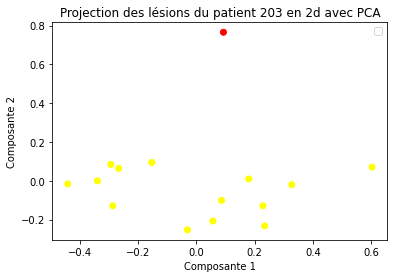

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


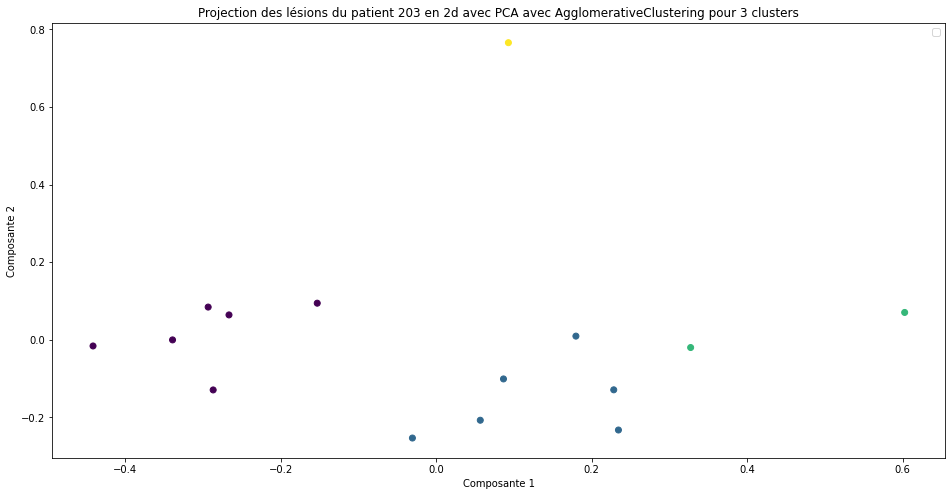

No handles with labels found to put in legend.


(26, 25)


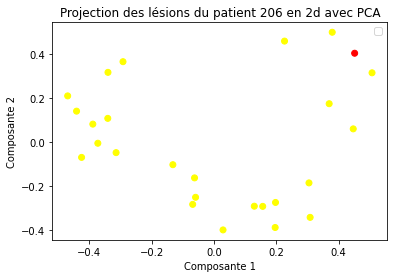

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 1 dont 0 faux positifs


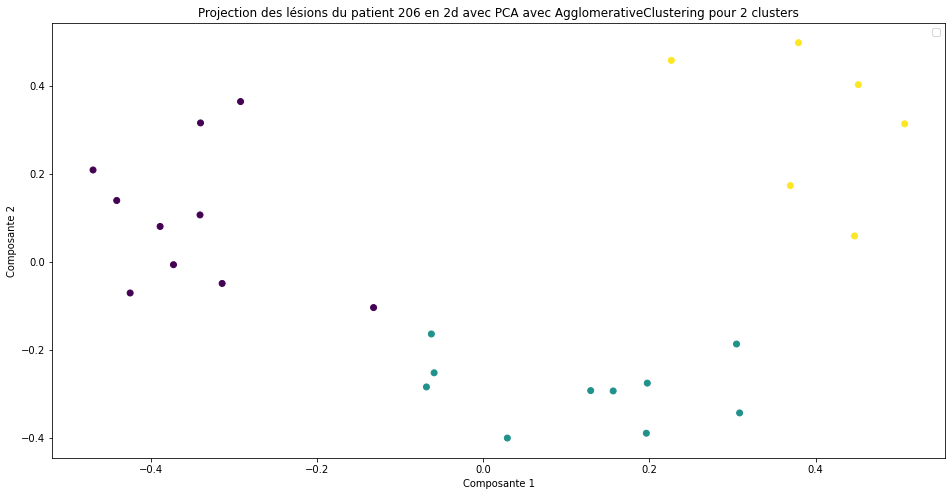

No handles with labels found to put in legend.


(14, 13)


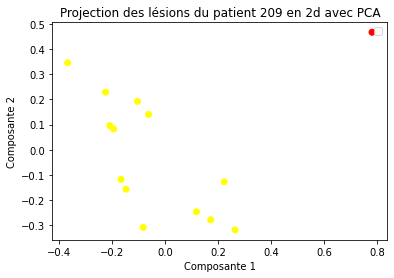

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


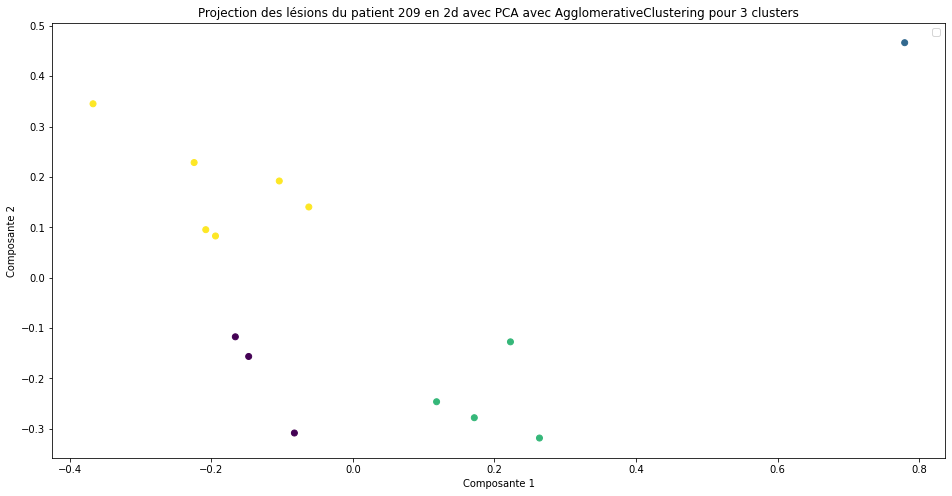

No handles with labels found to put in legend.


(11, 10)


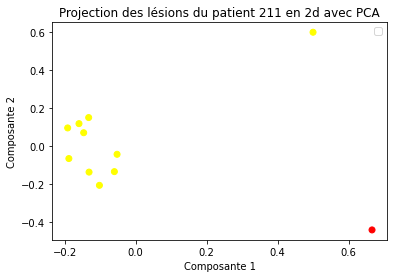

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


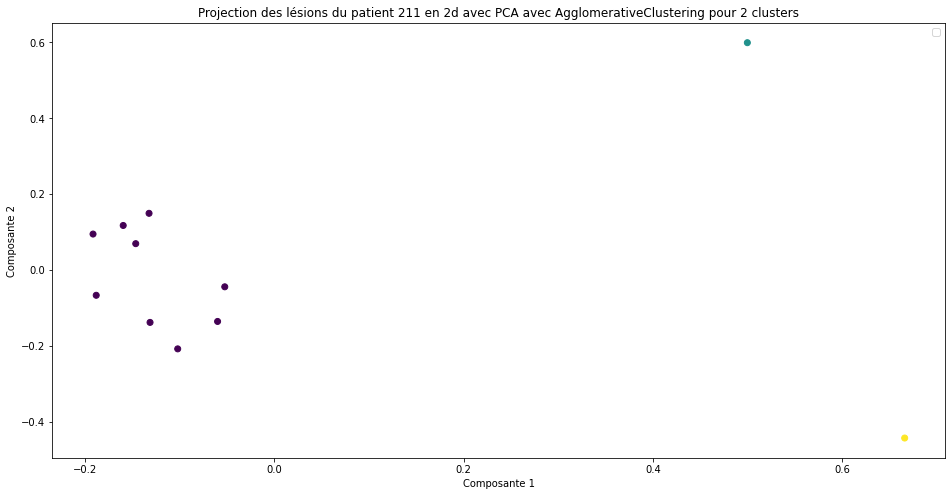

No handles with labels found to put in legend.


(19, 18)


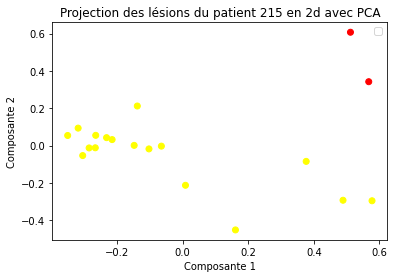

No handles with labels found to put in legend.


Le clustering unique trouve 0 unique dont 0 sur 2 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 2 VPC sur 2 dont 0 faux positifs


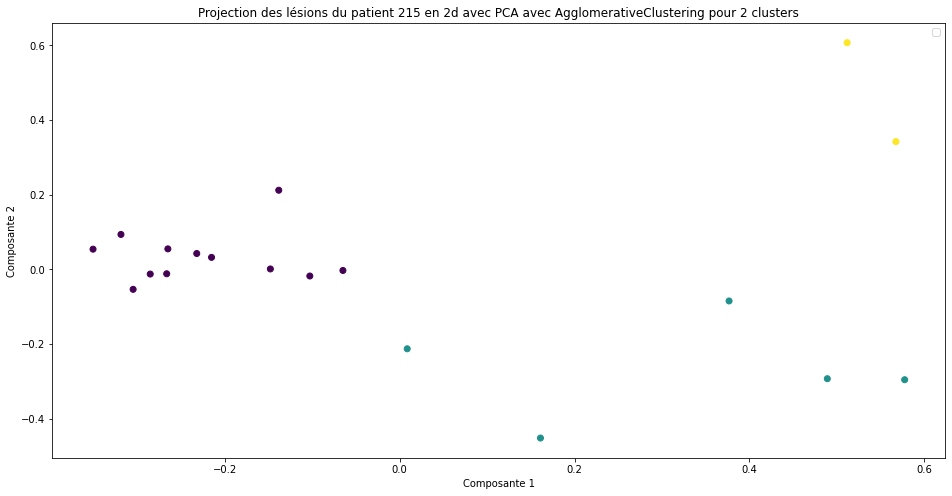

No handles with labels found to put in legend.


(25, 24)


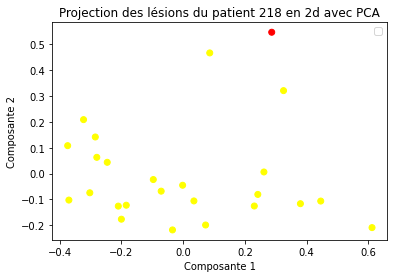

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs


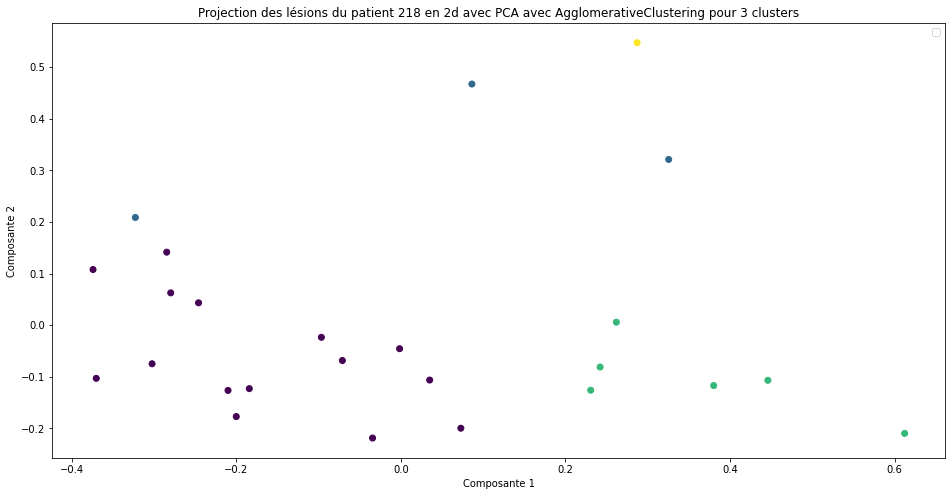

No handles with labels found to put in legend.


(8, 7)


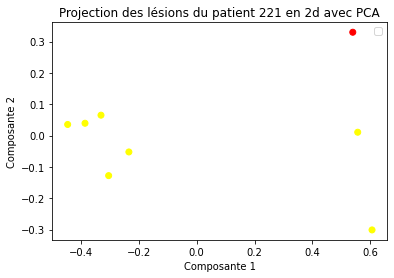

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


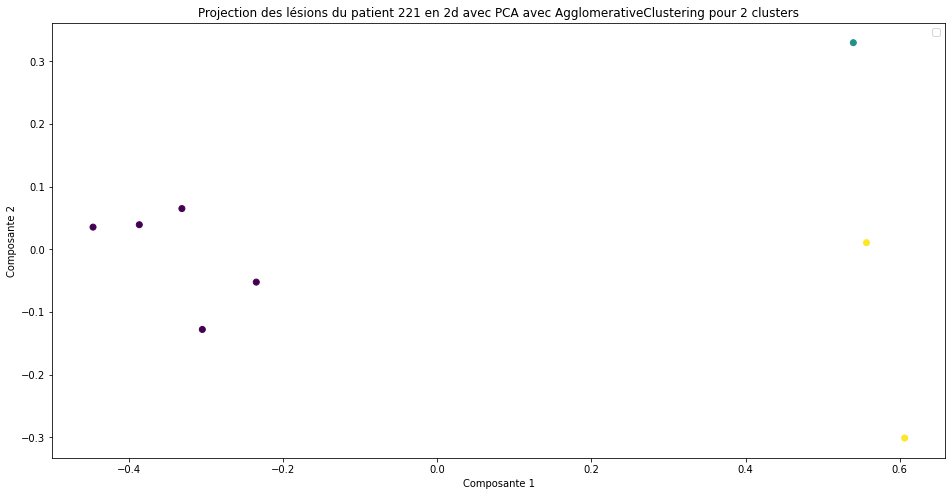

la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est 65.51724137931035 %
Pour les clusters uniques, rappel : 55.55555555555556 % précision : 58.82352941176471 % et f1 = 57.142857142857146
Pour les clusters uniques + petit cluster , rappel : 77.77777777777779 % précision : 40.0 % et f1 = 52.83018867924528
Pour les clusters uniques + petit cluster , spécificité : 95.33333333333333 % 


In [74]:
import sklearn as sk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from b_cubed import calc_b3
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import VarianceThreshold


from sklearn.cluster import AgglomerativeClustering

nb_cas_silhouette_b3=0
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0
nb_testés_total=0

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  nb_images=nb_images+len(patients[k])
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)

  pca = PCA(len(patients[k]))
  X = pca.fit_transform(X)

  selector = VarianceThreshold(threshold = 0.000001)
  X = selector.fit_transform(X)

  print(X.shape)

  silhouette_vals=[]
  calc_b3_vals=[]

  K = range(3,6) #test de 2 à 5 clusters
  for o in K:
    clustering = KMeans(n_clusters=o).fit(X)
    labels = clustering.labels_
    calc_b3_vals.append(calc_b3(y, labels)[0])
    silhouette_vals.append(np.mean(silhouette_score(X,labels)))

  '''plt.figure(figsize=(16,8))
  plt.plot(K, calc_b3_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('b3 score')
  plt.title('The b3 score for the '+str(patient_id))
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(K, silhouette_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('silhouette')
  plt.title('The silhouette for the patient '+str(patient_id))
  plt.show()'''

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1], c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()

  idx_max=0
  max=-1
  for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette
    if silhouette_vals[k]>max:
      max=silhouette_vals[k]
      idx_max=k

  clustering = KMeans(n_clusters=idx_max+3)    #l'on utilise le nombre de clusters maximisant la silhouette
  prediction = clustering.fit_predict(X)

  #comparaison entre le vrai clustering et la prediction au niveau des VPC
  #premièrement on regarde le nombre de VPC repéré dans des clusters uniques

  index_VPC=[]
  nb_testés=0
  nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
  liste_clusters=[]
  for e in range(nb_clusters):
    liste_clusters.append([])

  for a in range(len(y)):
    if y[a]=="red":
      index_VPC.append(a) #index des VPC
    liste_clusters[prediction[a]].append(a) #liste des index par cluster
  
  clusters_unique=[]
  for g in range (nb_clusters):
    if len(liste_clusters[g])==1:
      nb_testés=nb_testés+1
      nb_testés_total=nb_testés_total+1
      clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
  
  nb_trouvés_unique=0
  for l in index_VPC:
    if l in clusters_unique:
      nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
  
  nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique
  nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique

  print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

  #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

  nb_VPC_total = nb_VPC_total + len(index_VPC)

  nb_trouvés_petit_cluster=0
  nb_cas_petit_cluster=0
  liste_index_petit_clusters=[]
  for r in range(len(liste_clusters)):
    if 1<len(liste_clusters[r])<=2:
      nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r])
      nb_testés=nb_testés+len(liste_clusters[r])
      nb_testés_total=nb_testés_total+len(liste_clusters[r])
      liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
  
  for g in liste_index_petit_clusters:
    for h in liste_clusters[g]:
      if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
        nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

  nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster
  nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster

  print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

  plt.figure(figsize=(16,8))
  plt.scatter(projectedPCA[: , 0] , projectedPCA[: , 1] , c = prediction)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()


  if np.argmax(calc_b3_vals) == np.argmax(silhouette_vals): #on regarde quelle est la proportion ou le meilleur score de la silhouette maximise également le score b3
    nb_cas_silhouette_b3=nb_cas_silhouette_b3+1

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

print("la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est " +str((nb_cas_silhouette_b3/len(patients))*100)+" %")
print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((nb_images-nb_testés_total)*100/nb_images)+ " % ")


## Clustering par agglomération

Le clustering agglomératif est le type le plus courant de clustering hiérarchique utilisé pour regrouper des objets en clusters en fonction de leur similitude. Il est également connu sous le nom de AGNES (Agglomerative Nesting).

L'algorithme commence par traiter chaque objet comme un cluster singleton. Ensuite, les paires de clusters sont fusionnées successivement jusqu'à ce que tous les clusters aient été fusionnés en un seul grand cluster contenant tous les objets. Le résultat est une représentation arborescente des objets, nommée dendrogramme.

explication du paramètre linkage : https://machinelearninggeek.com/agglomerative-clustering/

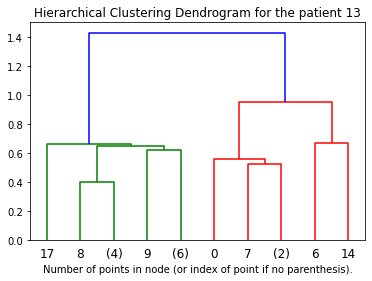

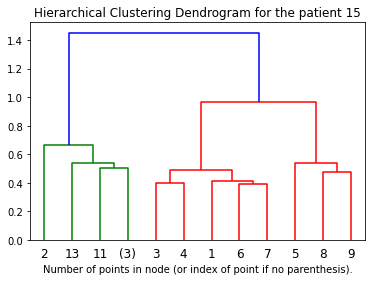

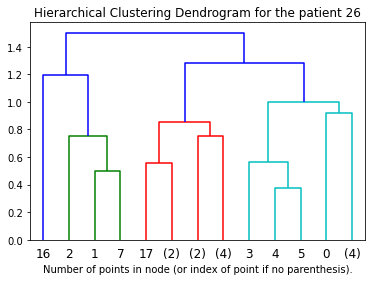

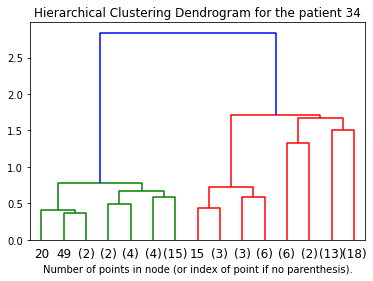

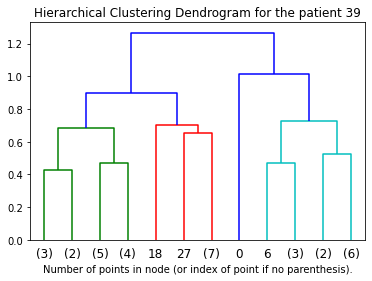

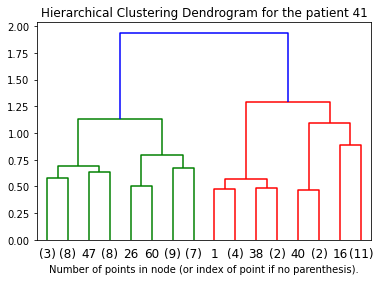

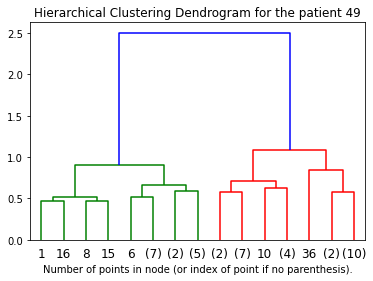

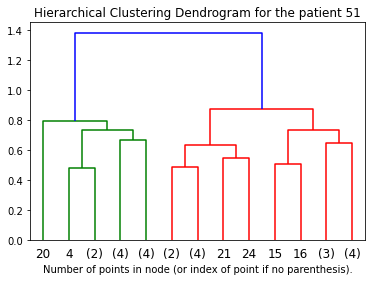

KeyboardInterrupt: ignored

In [59]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = X['concensus']
  X = X.drop(['patient_id','concensus','image'], axis=1)

  model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

  model = model.fit(X)
  plt.title('Hierarchical Clustering Dendrogram for the patient '+str(str(patient_id)))
  # plot the top three levels of the dendrogram
  plot_dendrogram(model, truncate_mode='level', p=3)
  plt.xlabel("Number of points in node (or index of point if no parenthesis).")
  plt.show()

No handles with labels found to put in legend.


(19, 18)


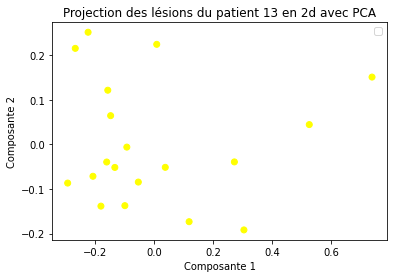

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


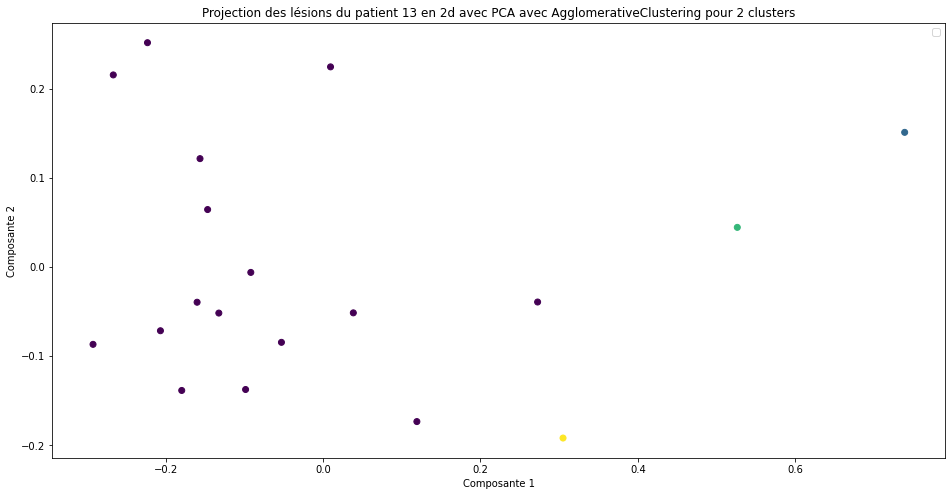

No handles with labels found to put in legend.


(14, 13)


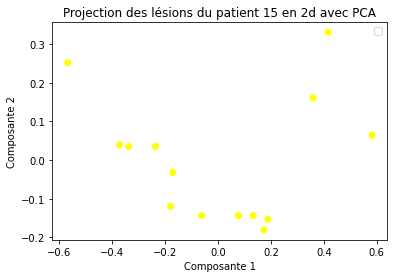

Le clustering unique trouve 2 unique dont 0 sur 0 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 4 faux positifs


No handles with labels found to put in legend.


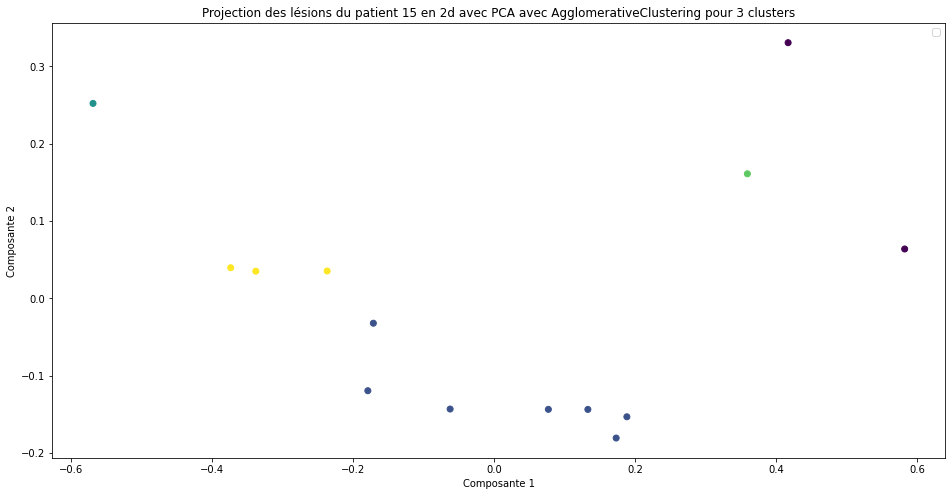

No handles with labels found to put in legend.


(21, 20)


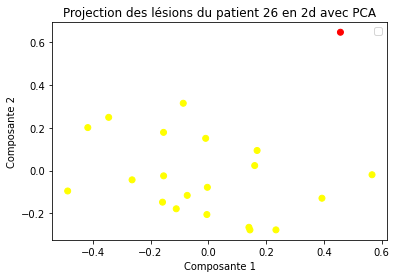

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 3 faux positifs


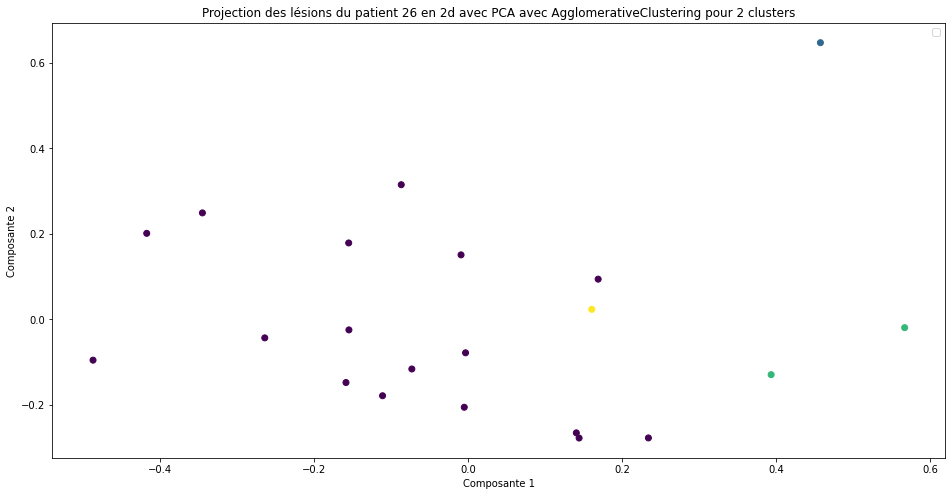

No handles with labels found to put in legend.


(81, 80)


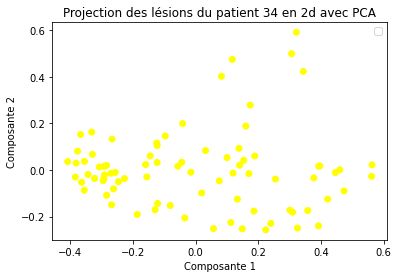

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


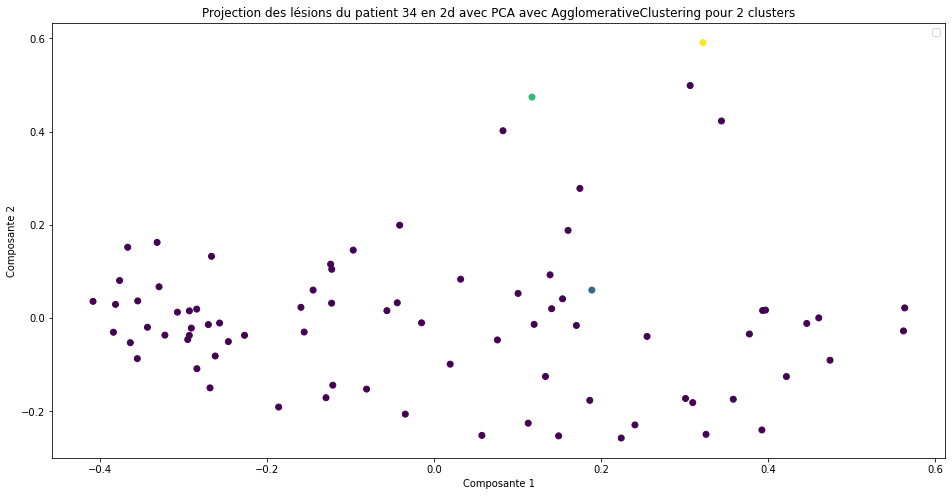

No handles with labels found to put in legend.


(36, 35)


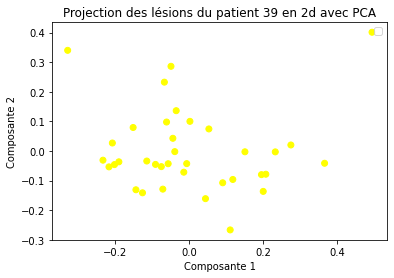

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


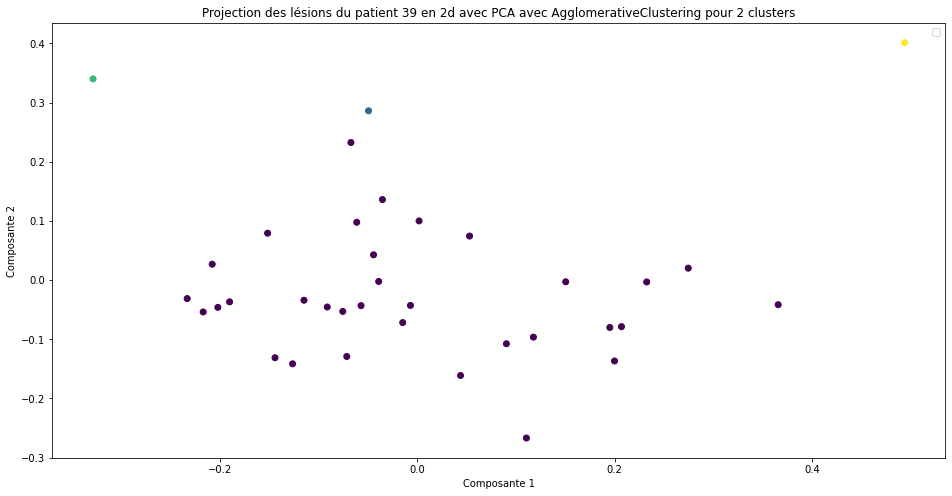

No handles with labels found to put in legend.


(61, 60)


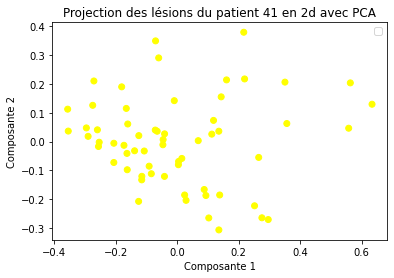

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


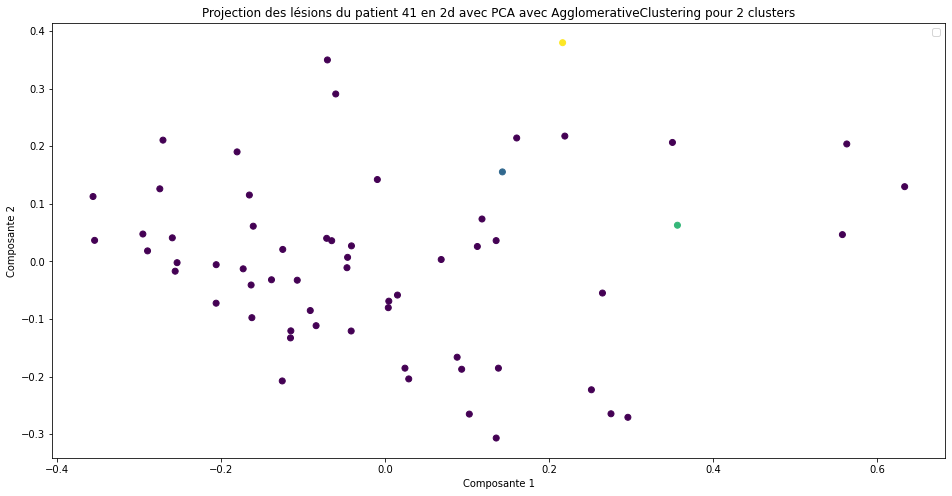

No handles with labels found to put in legend.


(46, 45)


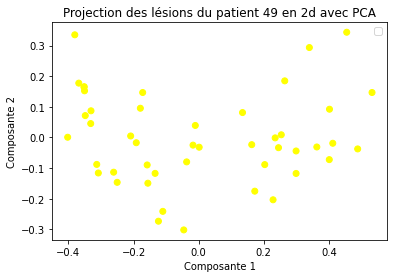

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


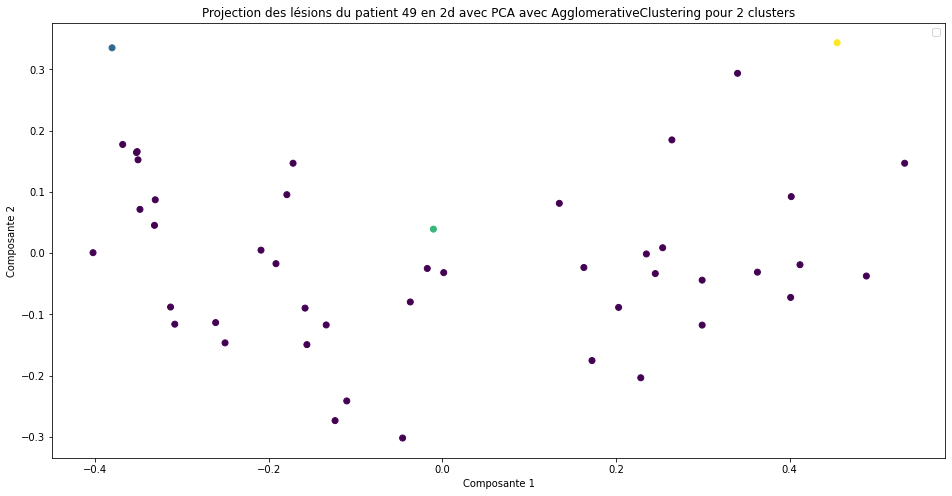

No handles with labels found to put in legend.


(29, 28)


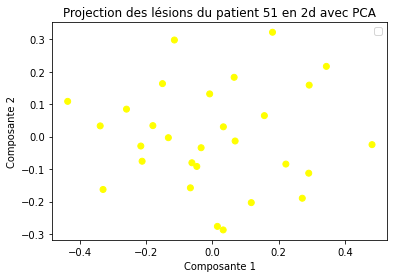

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


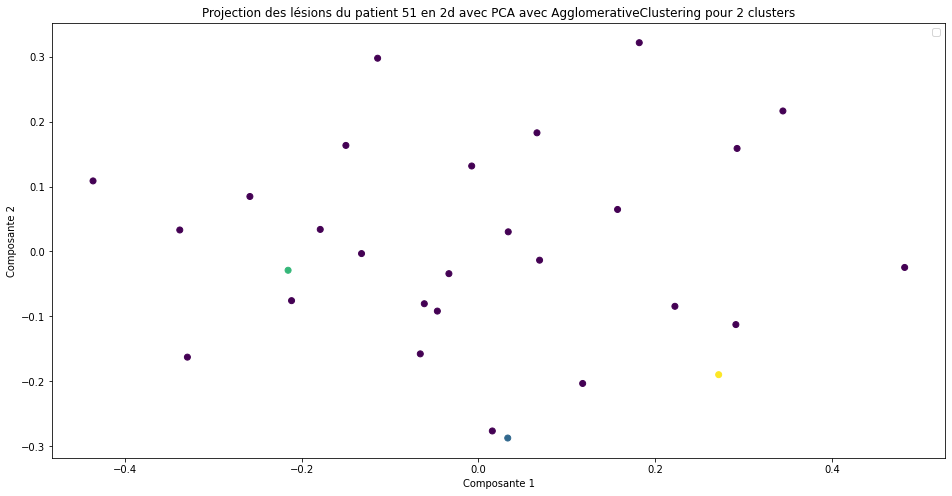

No handles with labels found to put in legend.


(23, 22)


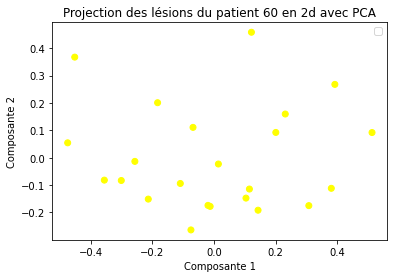

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 0 sur 0 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


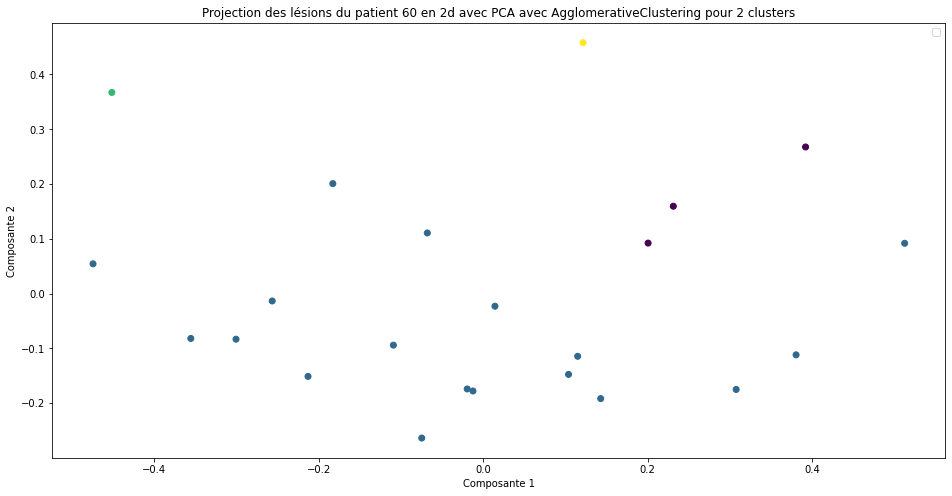

No handles with labels found to put in legend.


(40, 39)


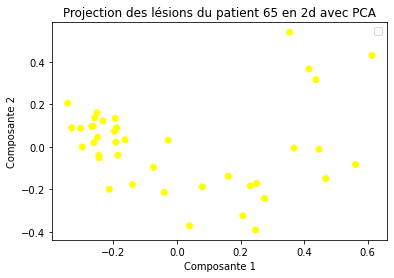

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 5 faux positifs


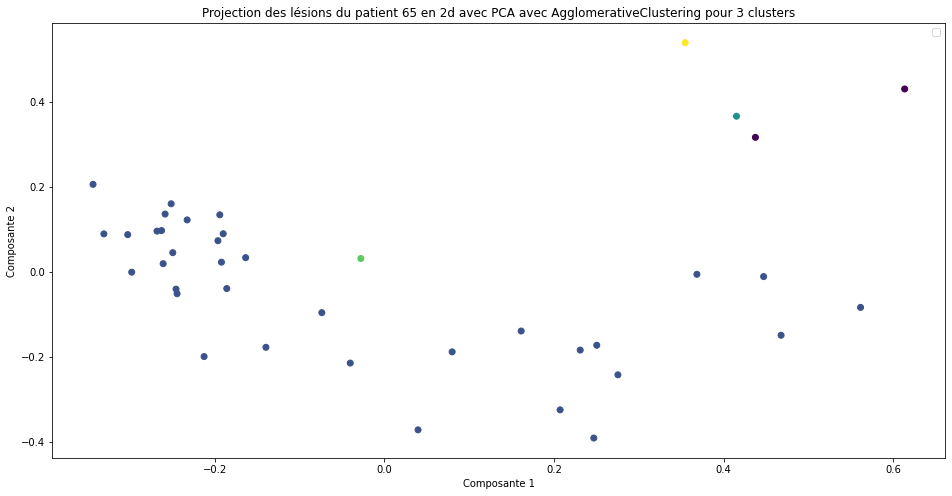

No handles with labels found to put in legend.


(39, 38)


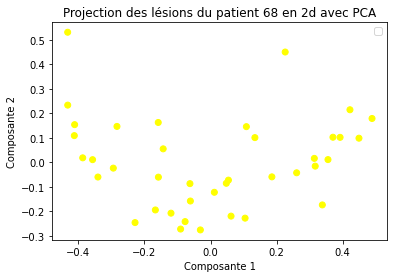

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


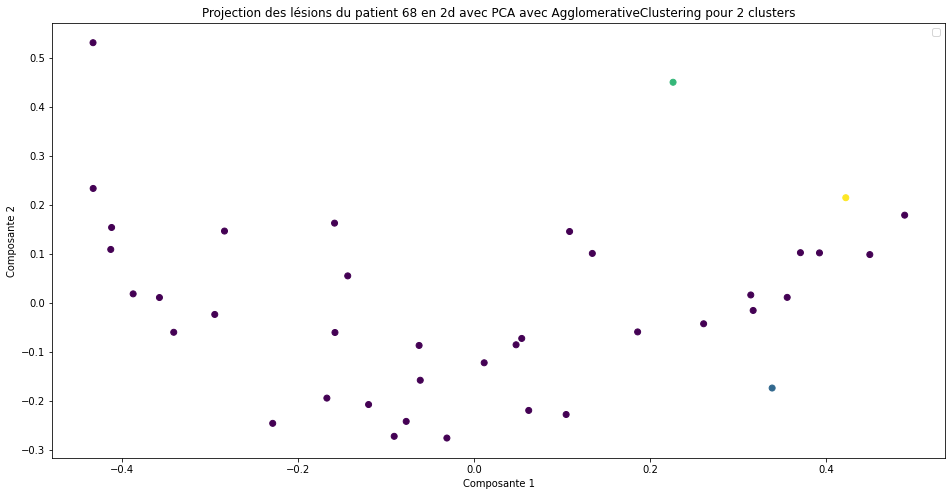

(18, 17)


No handles with labels found to put in legend.


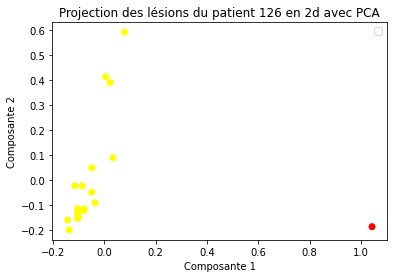

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 3 faux positifs


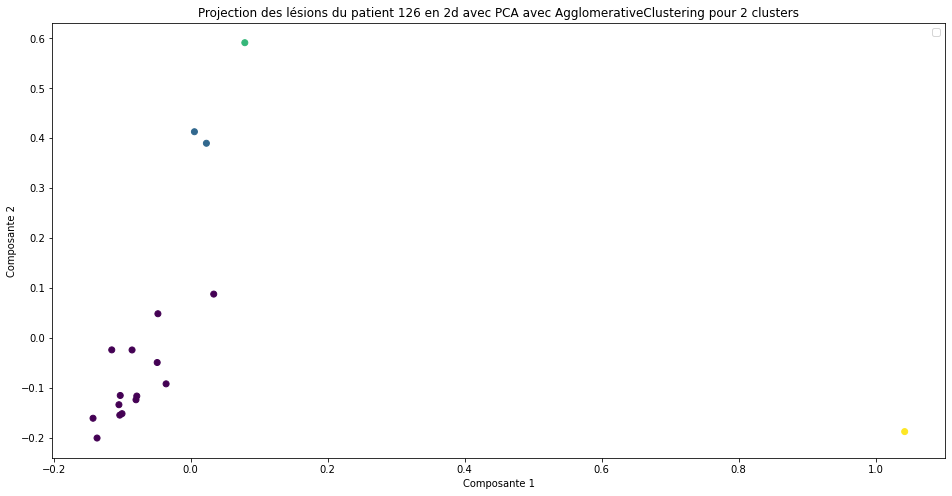

No handles with labels found to put in legend.


(18, 17)


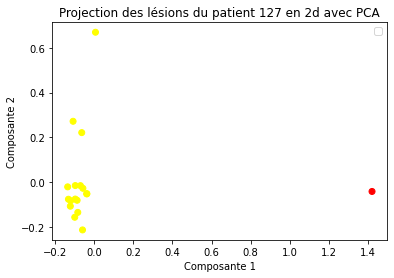

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


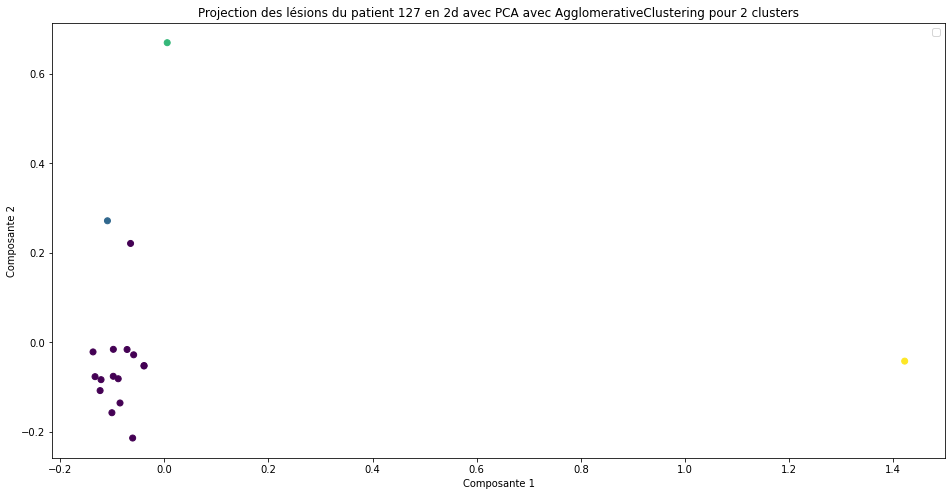

No handles with labels found to put in legend.


(8, 7)


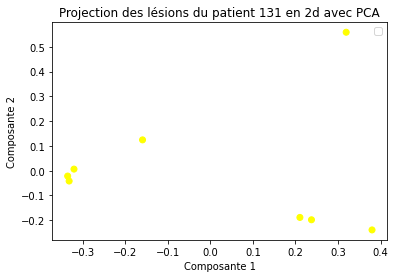

Le clustering unique trouve 2 unique dont 0 sur 0 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 2 faux positifs


No handles with labels found to put in legend.


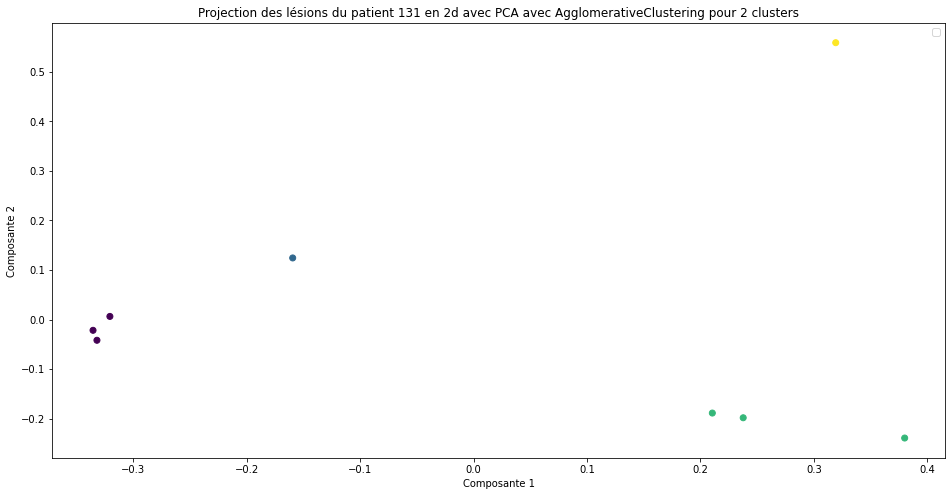

No handles with labels found to put in legend.


(10, 9)


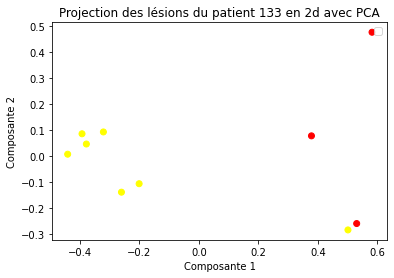

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 2 sur 3 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 3 VPC sur 3 dont 1 faux positifs


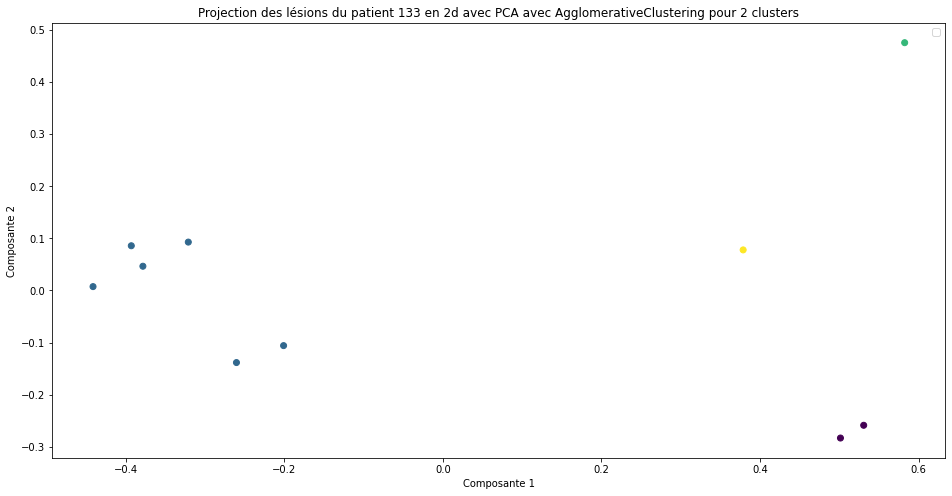

No handles with labels found to put in legend.


(24, 23)


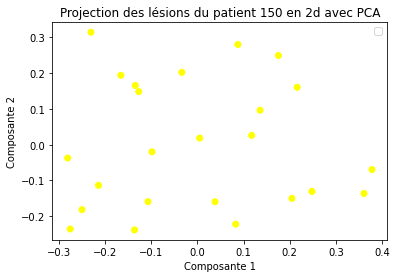

No handles with labels found to put in legend.


Le clustering unique trouve 4 unique dont 0 sur 0 VPC et 4 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 4 faux positifs


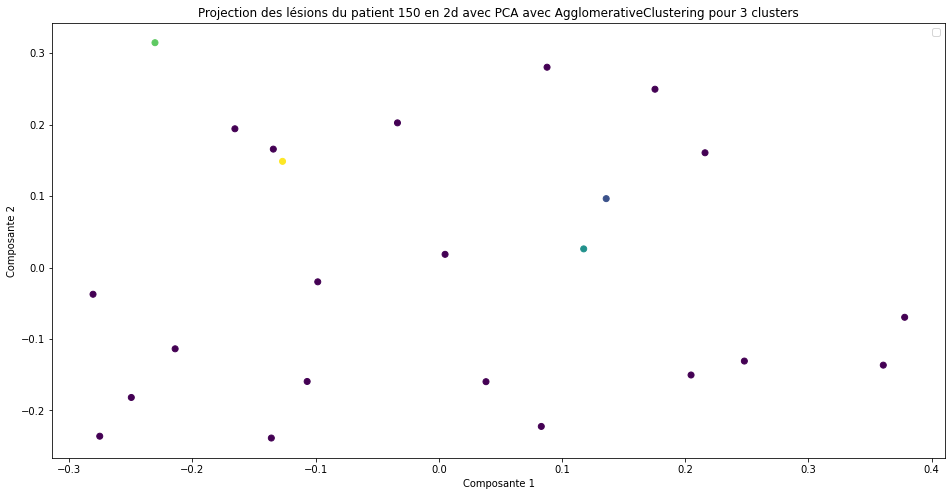

No handles with labels found to put in legend.


(18, 17)


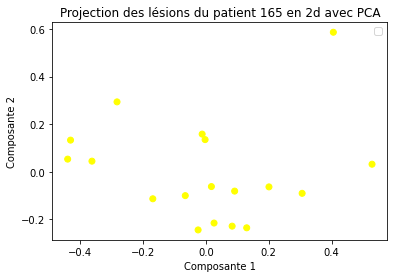

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


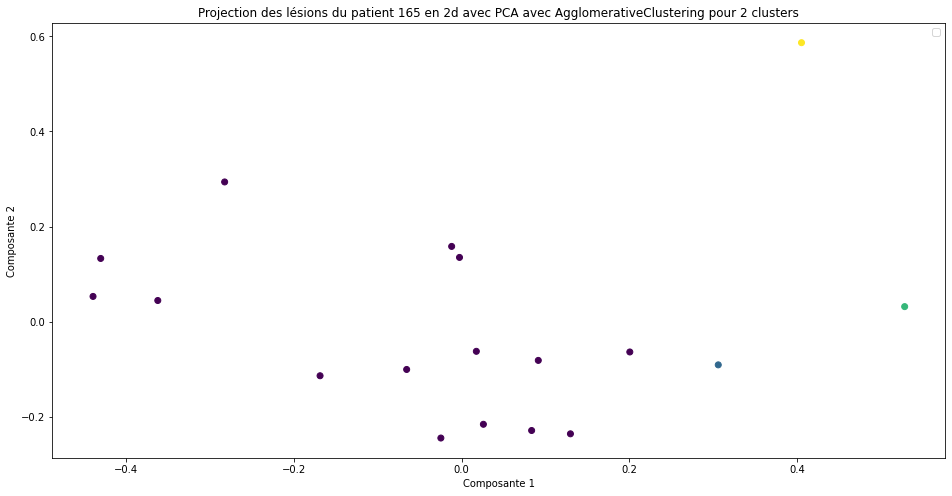

No handles with labels found to put in legend.


(19, 18)


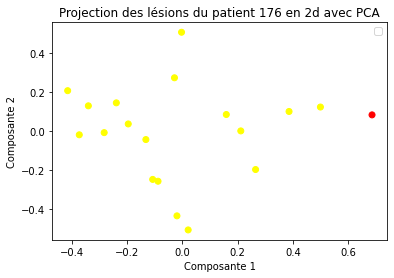

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


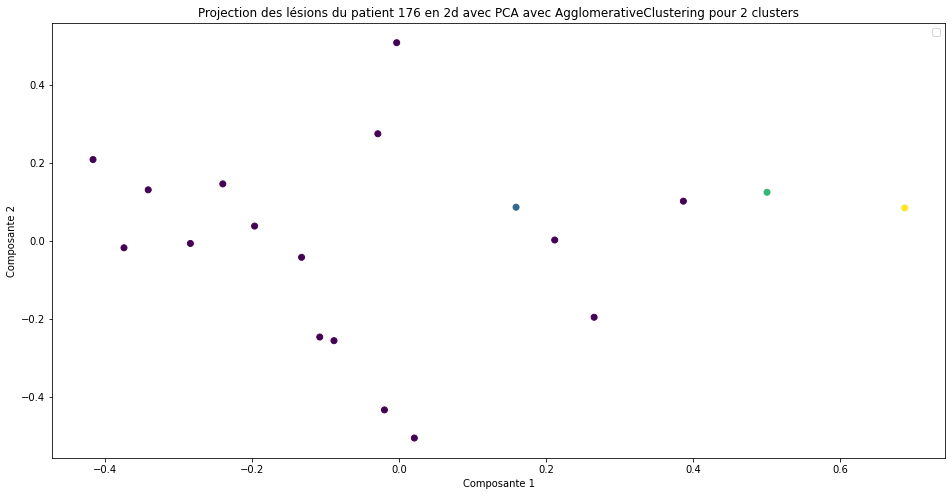

No handles with labels found to put in legend.


(18, 17)


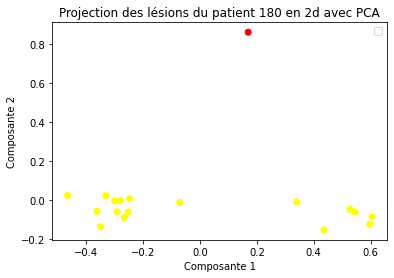

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


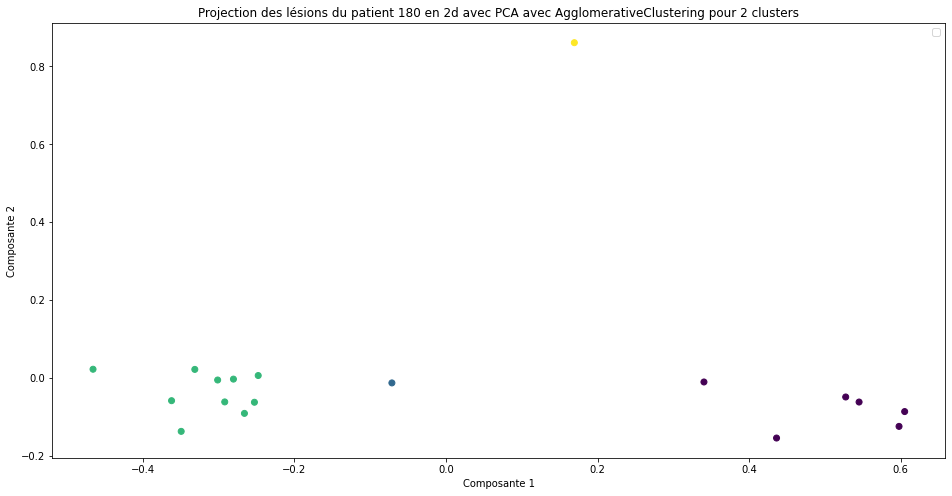

No handles with labels found to put in legend.


(59, 58)


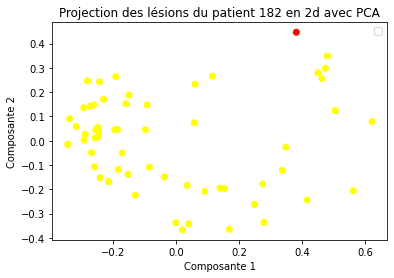

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 4 faux positifs


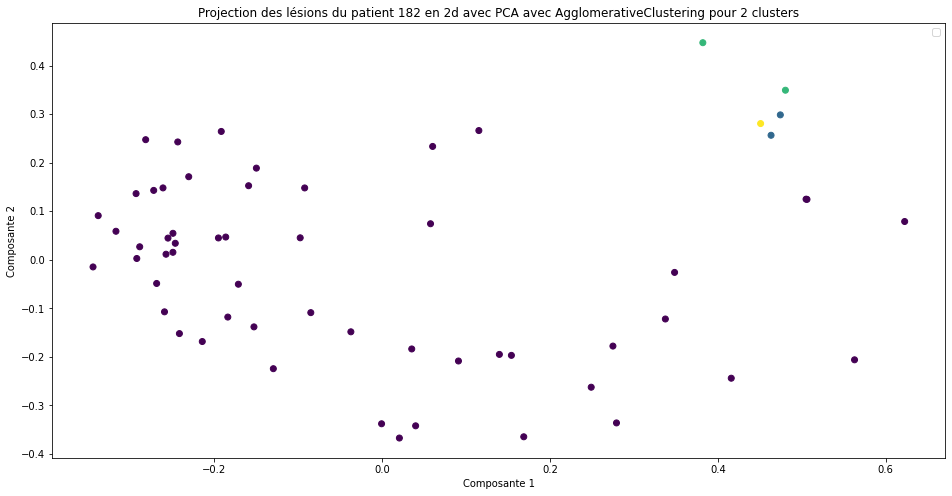

No handles with labels found to put in legend.


(19, 18)


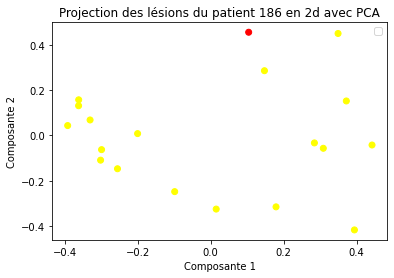

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


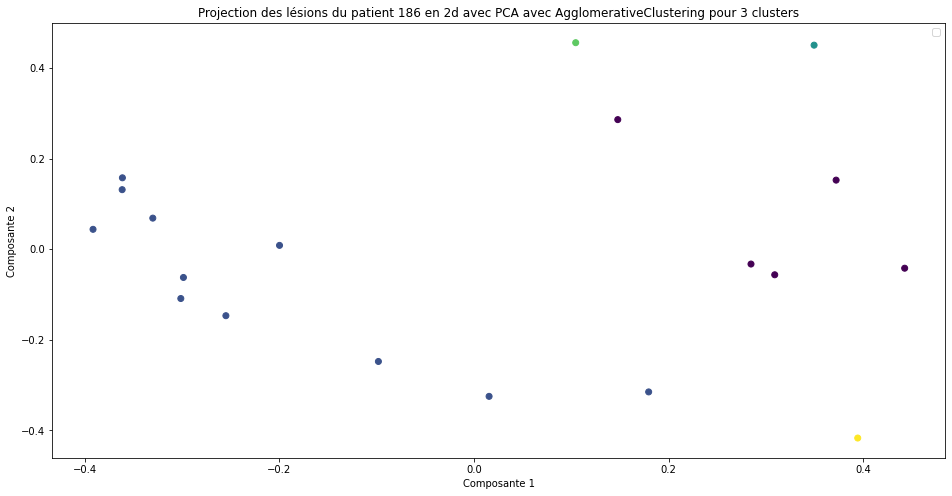

No handles with labels found to put in legend.


(12, 11)


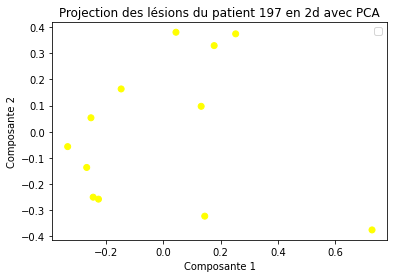

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 0 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs


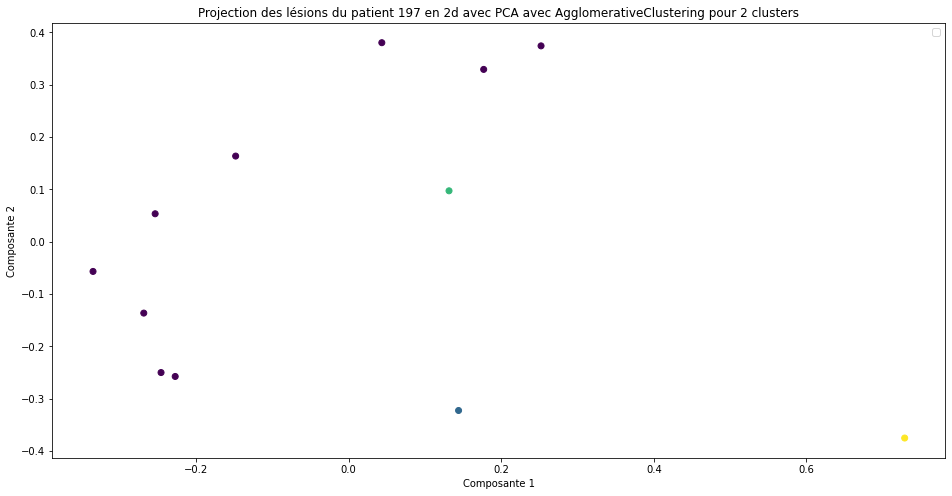

No handles with labels found to put in legend.


(15, 14)


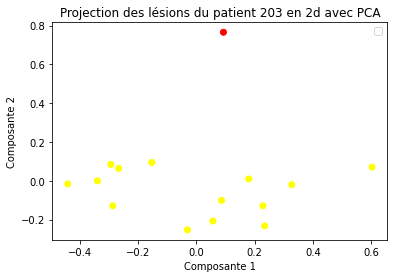

Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


No handles with labels found to put in legend.


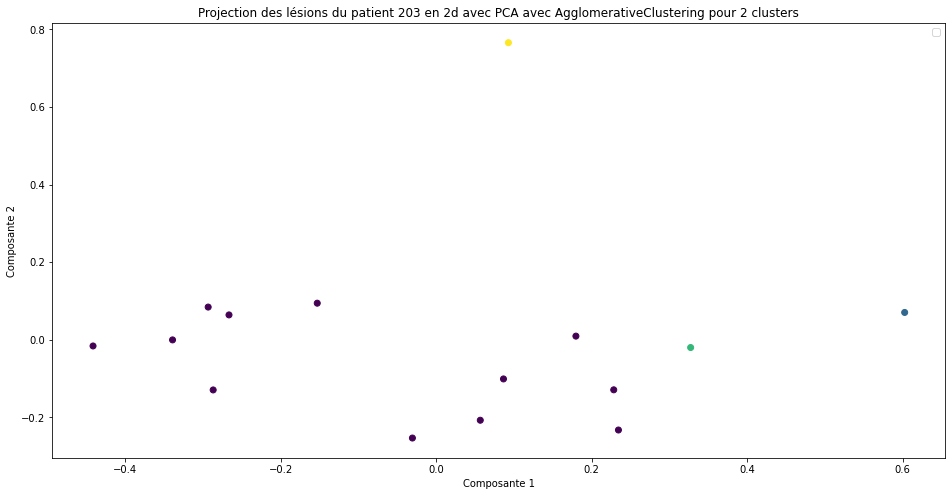

No handles with labels found to put in legend.


(26, 25)


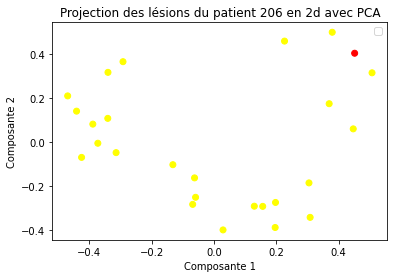

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 0 sur 1 VPC et 3 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 4 faux positifs


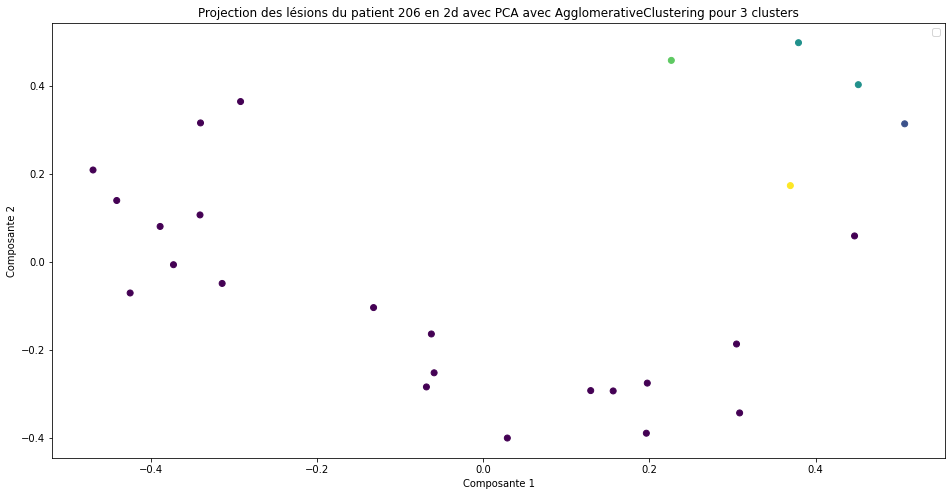

No handles with labels found to put in legend.


(14, 13)


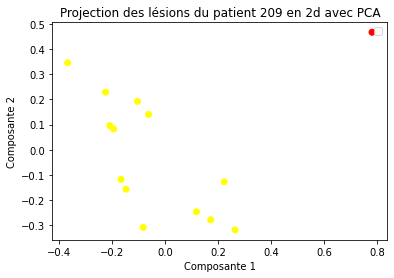

Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 1 faux positifs


No handles with labels found to put in legend.


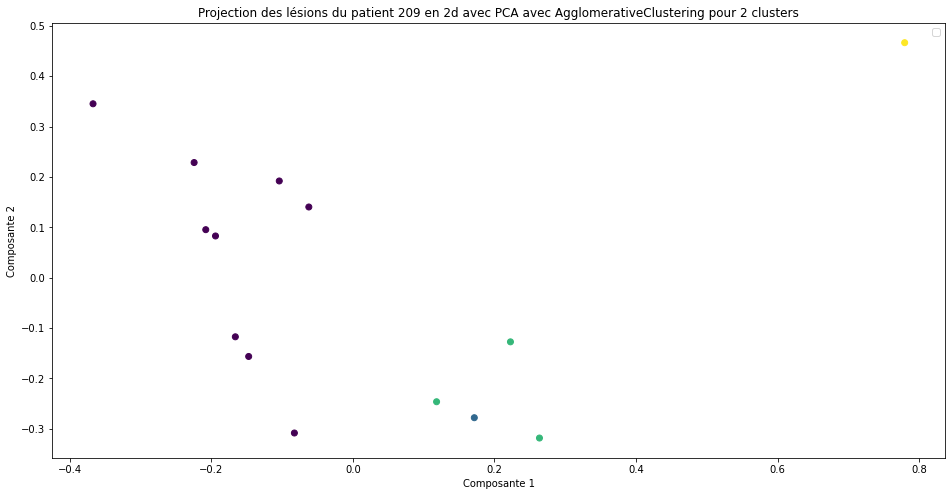

No handles with labels found to put in legend.


(11, 10)


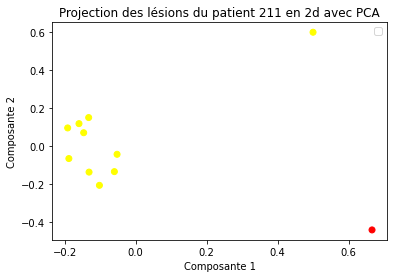

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


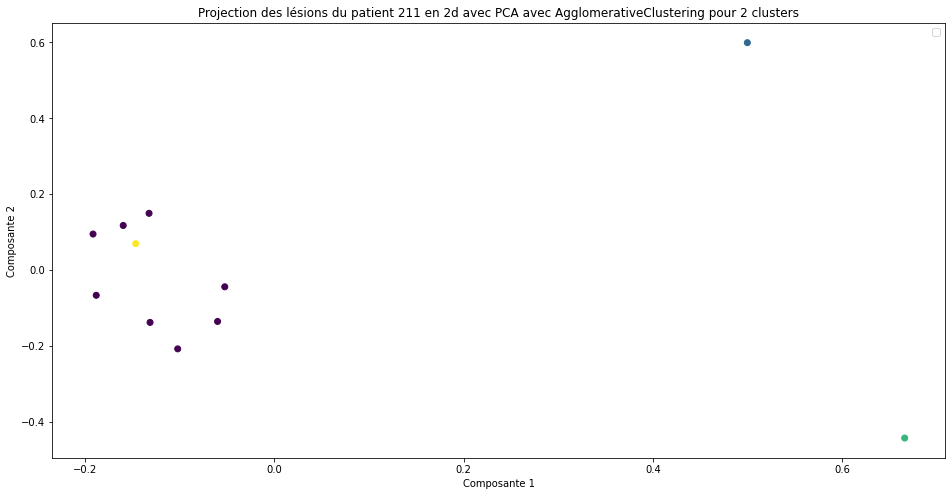

No handles with labels found to put in legend.


(19, 18)


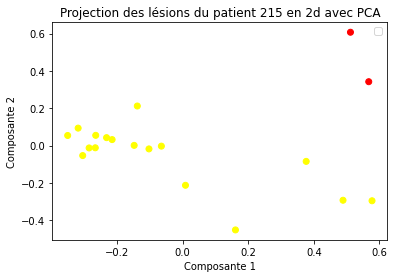

No handles with labels found to put in legend.


Le clustering unique trouve 1 unique dont 0 sur 2 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 2 VPC sur 2 dont 3 faux positifs


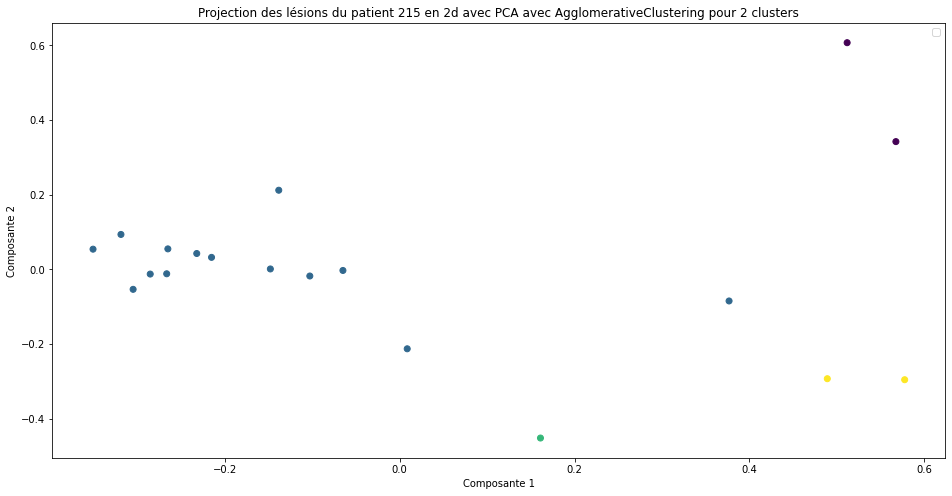

No handles with labels found to put in legend.


(25, 24)


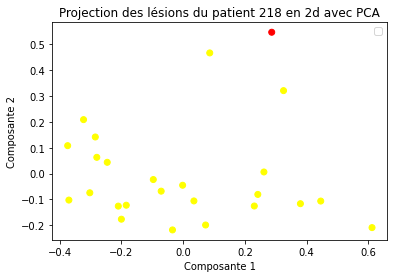

No handles with labels found to put in legend.


Le clustering unique trouve 2 unique dont 1 sur 1 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 3 faux positifs


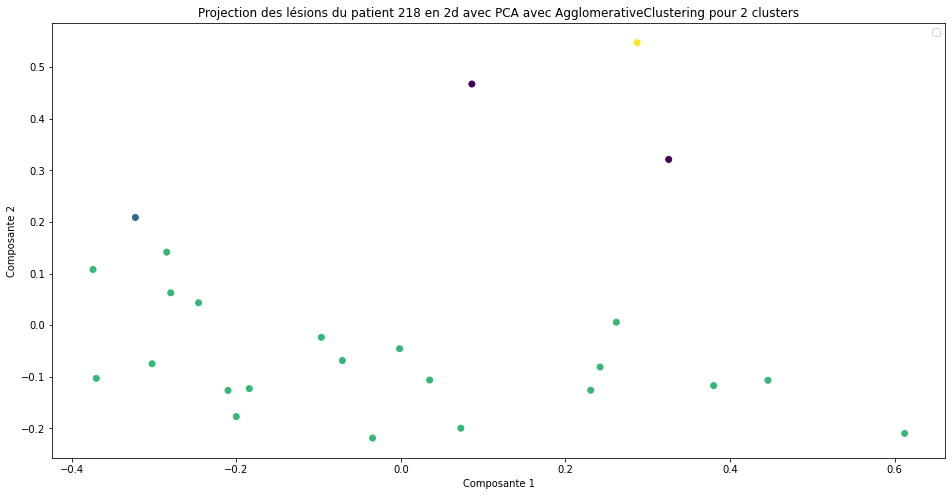

No handles with labels found to put in legend.


(8, 7)


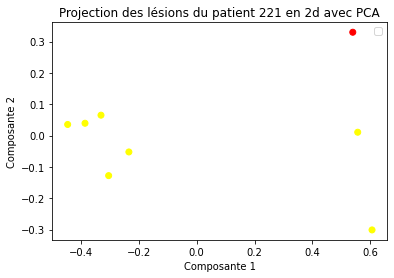

No handles with labels found to put in legend.


Le clustering unique trouve 3 unique dont 1 sur 1 VPC et 2 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs


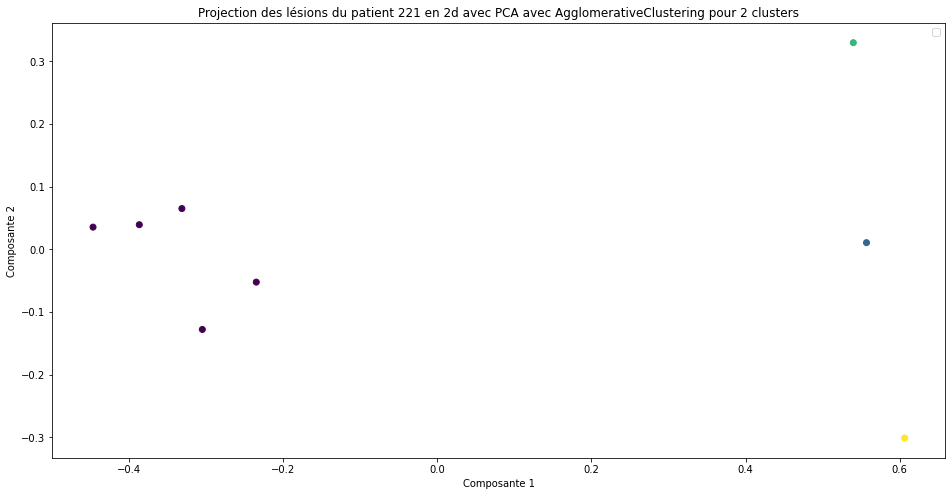

la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est 79.3103448275862 %
Pour les clusters uniques, rappel : 72.22222222222221 % précision : 17.333333333333336 % et f1 = 27.956989247311835
Pour les clusters uniques + petit cluster , rappel : 100.0 % précision : 18.556701030927837 % et f1 = 31.304347826086957
Pour les clusters uniques + petit cluster , spécificité : 87.06666666666666 % 


In [64]:
from sklearn.cluster import AgglomerativeClustering

nb_cas_silhouette_b3=0
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0
nb_testés_total=0

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  nb_images=nb_images+len(patients[k])
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)

  pca = PCA(len(patients[k]))
  X = pca.fit_transform(X)

  selector = VarianceThreshold(threshold = 0.000001)
  X = selector.fit_transform(X)

  print(X.shape)

  silhouette_vals=[]
  calc_b3_vals=[]

  K = range(4,6) #test de 2 à 5 clusters
  for o in K:
    clustering = AgglomerativeClustering(n_clusters=o, linkage='single').fit(X)
    labels = clustering.labels_
    calc_b3_vals.append(calc_b3(y, labels)[0])
    silhouette_vals.append(np.mean(silhouette_score(X,labels)))

  '''plt.figure(figsize=(16,8))
  plt.plot(K, calc_b3_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('b3 score')
  plt.title('The b3 score for the '+str(patient_id))
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(K, silhouette_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('silhouette')
  plt.title('The silhouette for the patient '+str(patient_id))
  plt.show()'''

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1], c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()

  idx_max=0
  max=-1
  for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette
    if silhouette_vals[k]>max:
      max=silhouette_vals[k]
      idx_max=k

  clustering = AgglomerativeClustering(n_clusters=idx_max+4,linkage='single')    #l'on utilise le nombre de clusters maximisant la silhouette
  prediction = clustering.fit_predict(X)

  #comparaison entre le vrai clustering et la prediction au niveau des VPC
  #premièrement on regarde le nombre de VPC repéré dans des clusters uniques

  index_VPC=[]
  nb_testés=0
  nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
  liste_clusters=[]
  for e in range(nb_clusters):
    liste_clusters.append([])

  for a in range(len(y)):
    if y[a]=="red":
      index_VPC.append(a) #index des VPC
    liste_clusters[prediction[a]].append(a) #liste des index par cluster
  
  clusters_unique=[]
  for g in range (nb_clusters):
    if len(liste_clusters[g])==1:
      nb_testés=nb_testés+1
      nb_testés_total=nb_testés_total+1
      clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
  
  nb_trouvés_unique=0
  for l in index_VPC:
    if l in clusters_unique:
      nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
  
  nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique
  nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique

  print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

  #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

  nb_VPC_total = nb_VPC_total + len(index_VPC)

  nb_trouvés_petit_cluster=0
  nb_cas_petit_cluster=0
  liste_index_petit_clusters=[]
  for r in range(len(liste_clusters)):
    if 1<len(liste_clusters[r])<=2:
      nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r])
      nb_testés=nb_testés+len(liste_clusters[r])
      nb_testés_total=nb_testés_total+len(liste_clusters[r])
      liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
  
  for g in liste_index_petit_clusters:
    for h in liste_clusters[g]:
      if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
        nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

  nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster
  nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster

  print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

  plt.figure(figsize=(16,8))
  plt.scatter(projectedPCA[: , 0] , projectedPCA[: , 1] , c = prediction)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()


  if np.argmax(calc_b3_vals) == np.argmax(silhouette_vals): #on regarde quelle est la proportion ou le meilleur score de la silhouette maximise également le score b3
    nb_cas_silhouette_b3=nb_cas_silhouette_b3+1

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

print("la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est " +str((nb_cas_silhouette_b3/len(patients))*100)+" %")
print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((nb_images-nb_testés_total)*100/nb_images)+ " % ")


  

##Clustering par Mean Shift



Le Mean Shift est un algorithme itératif qui a pour objectif de faire converger un point vers le maximum local le plus proche :

On commence par choisir un point de départ P.
On cherche l'ensemble E des points qui sont dans le voisinage de P.
On déplace P vers l'isobarycentre de E.
On réitère depuis l'étape 2 jusqu'à convergence.
Les déplacements successifs vers l'isobarycentre font converger le point P vers les zones de fortes densités.

explication du mean shift : https://www.youtube.com/watch?v=3ERPpzrDkVg

In [ ]:
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from itertools import cycle

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)

  bandwidth = estimate_bandwidth(X)

  ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
  ms.fit(X)
  labels = ms.labels_
  print(labels)
  cluster_centers = ms.cluster_centers_

  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print("number of estimated clusters : %d" % n_clusters_)

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1],c=labels)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.show()

ValueError: ignored

In [ ]:
from sklearn.cluster import DBSCAN
from b_cubed import calc_b3

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)
  
  calc_b3_vals=[]
  silhouette_vals=[]

  eps_range = [eps*0.5 for eps in range(1,10)]
  min_samples_range = [min_samples for min_samples in range(1,7)]
  axe_x=[]
  axe_y=[]
  params=[]

  pca = PCA(len(patients[k]))
  projectedPCA = pca.fit_transform(X)

  for eps in eps_range:
    for min_samples in min_samples_range :
      clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(projectedPCA) 
      labels = clustering.labels_
      print(labels)
      calc_b3_vals.append(calc_b3(y, labels)[0])
      silhouette_vals.append(np.mean(silhouette_score(X,labels)))
      axe_x.append(eps)
      axe_y.append(min_samples)
      params.append((eps,min_samples))
  
  max=0
  idx_max=0
  for k in range(len(calc_b3_vals)):
    if calc_b3_vals[k]> max:
      idx_max=k
      max=calc_b3_vals[k]

  print(params)
  print(calc_b3_vals[idx_max])
  print(params[idx_max])
  clustering = DBSCAN(eps=params[idx_max][0], min_samples=params[idx_max][1]).fit(projectedPCA)  #params[idx_max][1
  labels = clustering.labels_
  print(labels)

  '''fig = plt.figure()
  ax = fig.add_subplot(111,projection='3d')
  plt.scatter(axe_x,axe_y,calc_b3_vals,c=calc_b3_vals)
  plt.show()'''

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1],c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.show()

  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1],c=labels)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA avec DBSCAN")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering


nb_cas_silhouette_b3=0
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)

  #pca = PCA(len(patients[k]))
  #X = pca.fit_transform(X)

  #tsne = TSNE(n_components=3) 0% VPC
  #X = tsne.fit_transform(X)

  iso = Isomap(n_neighbors=1, n_components=2)
  X = iso.fit_transform(X)

  #lle = LocallyLinearEmbedding(n_components=len(patients[k])-1) 6% VPC
  #X = lle.fit_transform(X)

  silhouette_vals=[]
  calc_b3_vals=[]

  K = range(2,6) #test de 2 à 5 clusters
  for o in K:
    clustering = AgglomerativeClustering(n_clusters=o, linkage='single').fit(X)
    labels = clustering.labels_
    calc_b3_vals.append(calc_b3(y, labels)[0])
    silhouette_vals.append(np.mean(silhouette_score(X,labels)))

  plt.figure(figsize=(16,8))
  plt.plot(K, calc_b3_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('b3 score')
  plt.title('The b3 score for the '+str(patient_id))
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(K, silhouette_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('silhouette')
  plt.title('The silhouette for the patient '+str(patient_id))
  plt.show()

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1], c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()


  idx_max=0
  max=-1
  for k in range(len(silhouette_vals)):
    if silhouette_vals[k]>max:
      max=silhouette_vals[k]
      idx_max=k

  clustering = SpectralClustering(n_clusters=idx_max+2)    #l'on utilise le nombre de clusters maximisant la silhouette
  prediction = clustering.fit_predict(X)

  #comparaison entre le vrai clustering et la prediction au niveau des VPC
  #premièrement on regarde le nombre de VPC repéré dans des clusters uniques 
  index_VPC=[]
  nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
  liste_clusters=[]
  for e in range(nb_clusters):
    liste_clusters.append([])

  for a in range(len(y)):
    if y[a]=="red":
      index_VPC.append(a) #index des VPC
    liste_clusters[prediction[a]].append(a) #liste des index par cluster
  
  clusters_unique=[]
  for g in range (nb_clusters):
    if len(liste_clusters[g])==1:
      clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
  
  nb_trouvés=0
  for l in index_VPC:
    if l in clusters_unique:
      nb_trouvés=nb_trouvés+1 #on comptabilise les clusters uniques étant réellement des VPC 
  
  nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés
  nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés
  
  print("Le clustering trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés)+ " faux positifs")

  #dans un second temps on identifie le cluster possédant le moins d'individus et on regarde le nombre de VPC à l'intérieur

  if not clusters_unique:
    taille_clusters=[]
    for t in range(len(liste_clusters)):
      taille_clusters.append(len(liste_clusters[t]))
    indice_cluster_min = taille_clusters.index(min(taille_clusters))

    if len(liste_clusters[indice_cluster_min])<=4:
      for l in index_VPC:
        if l in liste_clusters[indice_cluster_min]:
          nb_trouvés=nb_trouvés+1 #on comptabilise les vrai VPC dans notre plus petit cluster
      nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster +len(liste_clusters[indice_cluster_min])- nb_trouvés

      print("Le clustering trouve "+str(nb_trouvés)+" VPC sur "+str(len(index_VPC))+" dans le plus petit cluster dont "+str(len(liste_clusters[indice_cluster_min])- nb_trouvés)+ " faux négatifs ")

  nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster+nb_trouvés
  nb_VPC_total = nb_VPC_total + len(index_VPC)

  plt.figure(figsize=(16,8))
  plt.scatter(projectedPCA[: , 0] , projectedPCA[: , 1] , c = prediction)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()


  if np.argmax(calc_b3_vals) == np.argmax(silhouette_vals):
    nb_cas_silhouette_b3=nb_cas_silhouette_b3+1

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

print("la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est " +str((nb_cas_silhouette_b3/len(patients))*100)+" %")
print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

nb_cas_silhouette_b3=0
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0

for k in range (len(patients)):
  patient_id=patients[k]["patient_id"][0]
  X=patients[k]
  y = deepcopy(X['concensus'])
  for m in range(len(y)):
    if y[m]==0:
      y[m]="red"
    else:
      y[m]="yellow"
  X = X.drop(['patient_id','concensus','image'], axis=1)

  pca = PCA(len(patients[k]))
  X = pca.fit_transform(X)

  #tsne = TSNE(n_components=3) 0% VPC
  #X = tsne.fit_transform(X)

  #iso = Isomap(n_neighbors=1, n_components=2)
  #X = iso.fit_transform(X)

  #lle = LocallyLinearEmbedding(n_components=len(patients[k])-1) 6% VPC
  #X = lle.fit_transform(X)

  distortions = []
  silhouette_vals = []
  calc_b3_vals = []
  K = range(2,6) #test de 2 à 5 clusters
  for o in K:
      kmeanModel = KMeans(n_clusters=o)
      kmeanModel.fit(X)
      distortions.append(kmeanModel.inertia_)
      silhouette_vals.append(np.mean(silhouette_score(X,kmeanModel.labels_)))
      calc_b3_vals.append(calc_b3(y, kmeanModel.labels_)[0])

  idx_max=0
  max=-1
  for k in range(len(silhouette_vals)):
    if silhouette_vals[k]>max:
      max=silhouette_vals[k]
      idx_max=k

  kmeans = KMeans(idx_max+2)    #l'on utilise le nombre de clusters maximisant la silhouette
  prediction_Kmeans = kmeans.fit_predict(X)

  silhouette_vals=[]
  calc_b3_vals=[]

  K = range(2,6) #test de 2 à 5 clusters
  for o in K:
    clustering = AgglomerativeClustering(n_clusters=o, linkage='single').fit(X)
    labels = clustering.labels_
    calc_b3_vals.append(calc_b3(y, labels)[0])
    silhouette_vals.append(np.mean(silhouette_score(X,labels)))

  plt.figure(figsize=(16,8))
  plt.plot(K, calc_b3_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('b3 score')
  plt.title('The b3 score for the '+str(patient_id))
  plt.show()

  plt.figure(figsize=(16,8))
  plt.plot(K, silhouette_vals, 'bx-')
  plt.xlabel('k')
  plt.ylabel('silhouette')
  plt.title('The silhouette for the patient '+str(patient_id))
  plt.show()

  pca = PCA(2)
  pca.fit(X)
  projectedPCA = pca.fit_transform(X)
  plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1], c=y)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()

  idx_max=0
  max=-1
  for k in range(len(silhouette_vals)):
    if silhouette_vals[k]>max:
      max=silhouette_vals[k]
      idx_max=k

  clustering = AgglomerativeClustering(n_clusters=idx_max+2,linkage='single')    #l'on utilise le nombre de clusters maximisant la silhouette
  prediction_Agglomerative = clustering.fit_predict(X)

  compteur=1
  prediction=np.array([])
  for t in range(len(prediction_Agglomerative)):
    if np.count_nonzero(prediction_Agglomerative == prediction_Agglomerative[t])==1 or np.count_nonzero(prediction_Kmeans == prediction_Kmeans[t])==1:
      prediction = np.append(prediction,compteur)
      compteur=compteur+1
    else:
      prediction =np.append(prediction,0)


  print(prediction_Agglomerative)
  print(prediction_Kmeans)
  print(prediction)

  #comparaison entre le vrai clustering et la prediction au niveau des VPC
  #premièrement on regarde le nombre de VPC repéré dans des clusters uniques 
  index_VPC=[]
  nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
  liste_clusters=[]
  for e in range(nb_clusters):
    liste_clusters.append([])

  for a in range(len(y)):
    if y[a]=="red":
      index_VPC.append(a) #index des VPC
    liste_clusters[int(prediction[a])].append(a) #liste des index par cluster
  clusters_unique=[]
  for g in range (nb_clusters):
    if len(liste_clusters[g])==1:
      clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
  
  nb_trouvés=0
  for l in index_VPC:
    if l in clusters_unique:
      nb_trouvés=nb_trouvés+1 #on comptabilise les clusters uniques étant réellement des VPC 
  
  nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés
  nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés
  
  print("Le clustering trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés)+ " faux positifs")

  #dans un second temps on identifie le cluster possédant le moins d'individus et on regarde le nombre de VPC à l'intérieur

  if not clusters_unique:
    taille_clusters=[]
    for t in range(len(liste_clusters)):
      taille_clusters.append(len(liste_clusters[t]))
    indice_cluster_min = taille_clusters.index(min(taille_clusters))

    if len(liste_clusters[indice_cluster_min])<=1000:
      for l in index_VPC:
        if l in liste_clusters[indice_cluster_min]:
          nb_trouvés=nb_trouvés+1 #on comptabilise les vrai VPC dans notre plus petit cluster
      nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster +len(liste_clusters[indice_cluster_min])- nb_trouvés

      print("Le clustering trouve "+str(nb_trouvés)+" VPC sur "+str(len(index_VPC))+" dans le plus petit cluster dont "+str(len(liste_clusters[indice_cluster_min])- nb_trouvés)+ " faux négatifs ")

  nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster+nb_trouvés
  nb_VPC_total = nb_VPC_total + len(index_VPC)

  plt.figure(figsize=(16,8))
  plt.scatter(projectedPCA[: , 0] , projectedPCA[: , 1] , c = prediction)
  plt.title("Projection des lésions du patient " +str(patient_id)+ " en 2d avec PCA avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
  plt.xlabel('Composante 1')
  plt.ylabel('Composante 2')
  plt.legend()
  plt.show()


  if np.argmax(calc_b3_vals) == np.argmax(silhouette_vals):
    nb_cas_silhouette_b3=nb_cas_silhouette_b3+1

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

print("la proportion de cas ou le choix du nombre de clusters par la silhouette maximise le score b3 est " +str((nb_cas_silhouette_b3/len(patients))*100)+" %")
print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
